## Gaussian Copula Resmapling

In [1]:
import time
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
import matplotlib.pyplot as plt
import projplot.proj_plot as pjp
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

import jax
import jax.numpy as jnp
import jax.random as random

import pfjax as pf
from pfjax import particle_resamplers as resampler
from pfjax.models import BMModel
from pfjax.experimental.models import LotVolModelLog
import optax
from jax import lax
from functools import partial

import warnings
warnings.filterwarnings('ignore')

# again, this only works on startup!
from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
from pfjax.utils import lwgt_to_prob, continuous_cdf, interpolate_weights, argsort_marginal

# Brownian Motion Model

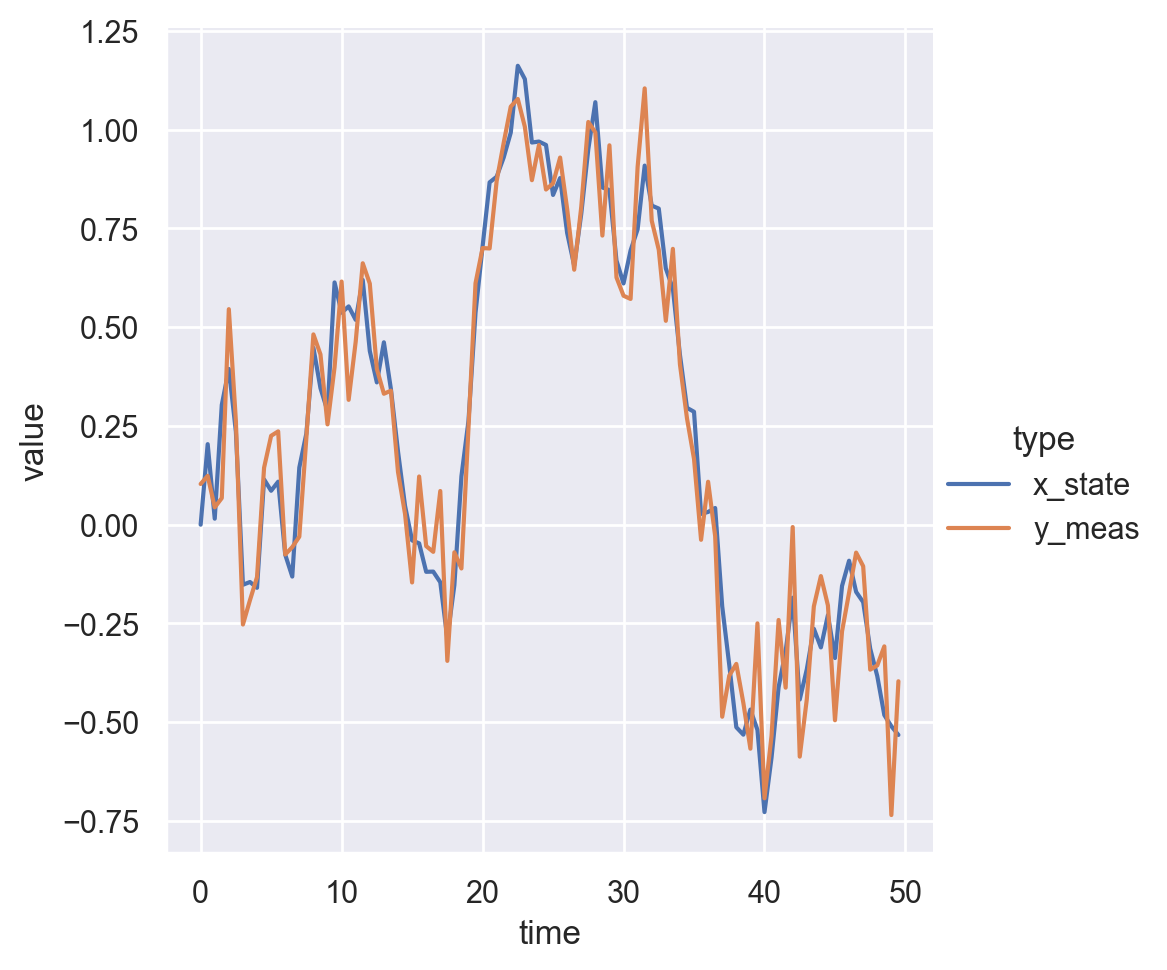

In [3]:
# parameter values
mu = 0.
sigma = .2
tau = .1
theta_true = jnp.array([mu, sigma, tau])

# data specification
dt = .5
n_obs = 100
x_init = jnp.array(0.)

# initial key for random numbers
key = jax.random.PRNGKey(0)

# simulate data
bm_model = BMModel(dt=dt)
key, subkey = jax.random.split(key)
y_meas, x_state = pf.simulate(
    model=bm_model,
    key=subkey,
    n_obs=n_obs,
    x_init=x_init,
    theta=theta_true
)

# plot data
plot_df = (pd.DataFrame({"time": jnp.arange(n_obs) * dt,
                         "x_state": jnp.squeeze(x_state),
                         "y_meas": jnp.squeeze(y_meas)})
           .melt(id_vars="time", var_name="type"))
sns.relplot(
    data=plot_df, kind="line",
    x="time", y="value", hue="type"
);

## Loglikelihood Comparisons

In [4]:
def resample_continuous_bm (key, x_particles_prev, logw):
    """
    Continuous CDF resampler for the Brownian motion model with drift
    """
    p_shape = x_particles_prev.shape
    n_particles = p_shape[0]
    prob = lwgt_to_prob(logw)

    sorted_marginals = argsort_marginal(x_particles_prev, prob)

    U = random.uniform(key, shape=(n_particles,))
    x_particles = jax.vmap(
        lambda u: continuous_cdf(sorted_marginals["x"], sorted_marginals["w"], u), in_axes = (0))(U)
    return {
        "x_particles": x_particles,
    }

def bm_loglik_exact(theta, y_meas):
    """
    Exact loglikelihood of the BM model.
    """
    theta = jnp.atleast_2d(theta)
    return jax.vmap(lambda _theta: bm_model.loglik_exact(
        y_meas=y_meas, 
        theta=_theta
    ))(theta)

def bm_loglik_basic(theta, y_meas, key, n_particles):
    """
    Basic particle filter approximation of the loglikelihood.
    """
    theta = jnp.atleast_2d(theta)
    subkeys = jax.random.split(key, num=theta.shape[0])
    return jax.vmap(lambda _theta, _key: pf.particle_filter(
        model=bm_model,
        key=_key,
        y_meas=y_meas,
        n_particles=n_particles,
        theta=_theta,
        history=False,
        score=False,
        fisher=False
    )["loglik"])(theta, subkeys)

def bm_loglik_cont_approx(theta, y_meas, key, n_particles):
    """
    particle filter approximation of the loglikelihood using continuous CDF approximation 
    """
    theta = jnp.atleast_2d(theta)
    subkeys = jax.random.split(key, num=theta.shape[0])
    return jax.vmap(lambda _theta, _key: pf.particle_filter(
        model=bm_model,
        key=_key,
        y_meas=y_meas,
        n_particles=n_particles,
        resampler=resample_continuous_bm,
        theta=_theta,
        history=False,
        score=False,
        fisher=False
    )["loglik"])(theta, subkeys)

def bm_loglik_rb(theta, y_meas, key, n_particles):
    """
    Rao-Blackwellized particle filter approximation of the loglikelihood.
    """
    theta = jnp.atleast_2d(theta)
    subkeys = jax.random.split(key, num=theta.shape[0])
    return jax.vmap(lambda _theta, _key: pf.particle_filter_rb(
        model=bm_model,
        key=_key,
        y_meas=y_meas,
        n_particles=n_particles,
        theta=_theta,
        history=False,
        score=False,
        fisher=False
    )["loglik"])(theta, subkeys)

In [5]:
# projection plot specification
n_pts = 100 # number of evaluation points per plot
theta_lims = jnp.array([[-.5, .5], [.1, .4], [.05, .2]])  # plot limits for each parameter
theta_names = ["mu", "sigma", "tau"] # parameter names

In [6]:
# projection plots for exact loglikelihood
df_exact = pjp.proj_plot(
    fun=jax.jit(partial(bm_loglik_exact, y_meas=y_meas)),
    x_opt=theta_true, 
    x_lims=theta_lims, 
    x_names=theta_names, 
    n_pts=n_pts,
    vectorized=True,
    plot=False
)

In [7]:
# projection plots for basic particle filter
n_particles_basic = 2500
key, subkey = jax.random.split(key)
bm_ll_basic = jax.jit(partial(bm_loglik_basic, y_meas=y_meas,
                             n_particles=n_particles_basic, key=subkey))

%timeit bm_ll_basic(theta_true)

df_basic = pjp.proj_plot(
    fun=bm_ll_basic,
    x_opt=theta_true, 
    x_lims=theta_lims, 
    x_names=theta_names, 
    n_pts=n_pts,
    vectorized=True,
    plot=False
)

44.8 ms ± 4.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
# projection plots for rao-blackwellized particle filter
n_particles_rb = 400
key, subkey = jax.random.split(key)
bm_ll_rb = jax.jit(partial(bm_loglik_rb, y_meas=y_meas,
                             n_particles=n_particles_rb, key=subkey))

%timeit bm_ll_rb(theta_true)

df_rb = pjp.proj_plot(
    fun=bm_ll_rb,
    x_opt=theta_true, 
    x_lims=theta_lims, 
    x_names=theta_names, 
    n_pts=n_pts,
    vectorized=True,
    plot=False
)

201 ms ± 14.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
# projection plots for continuous resampling particle filter
n_particles_cont = 2500
key, subkey = jax.random.split(key)
bm_ll_cont = jax.jit(partial(bm_loglik_cont_approx, y_meas=y_meas,
                             n_particles=n_particles_cont, key=subkey))

%timeit bm_ll_cont(theta_true)

df_cont = pjp.proj_plot(
    fun=bm_ll_cont,
    x_opt=theta_true, 
    x_lims=theta_lims, 
    x_names=theta_names, 
    n_pts=n_pts,
    vectorized=True,
    plot=False
)

1.1 s ± 6.67 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


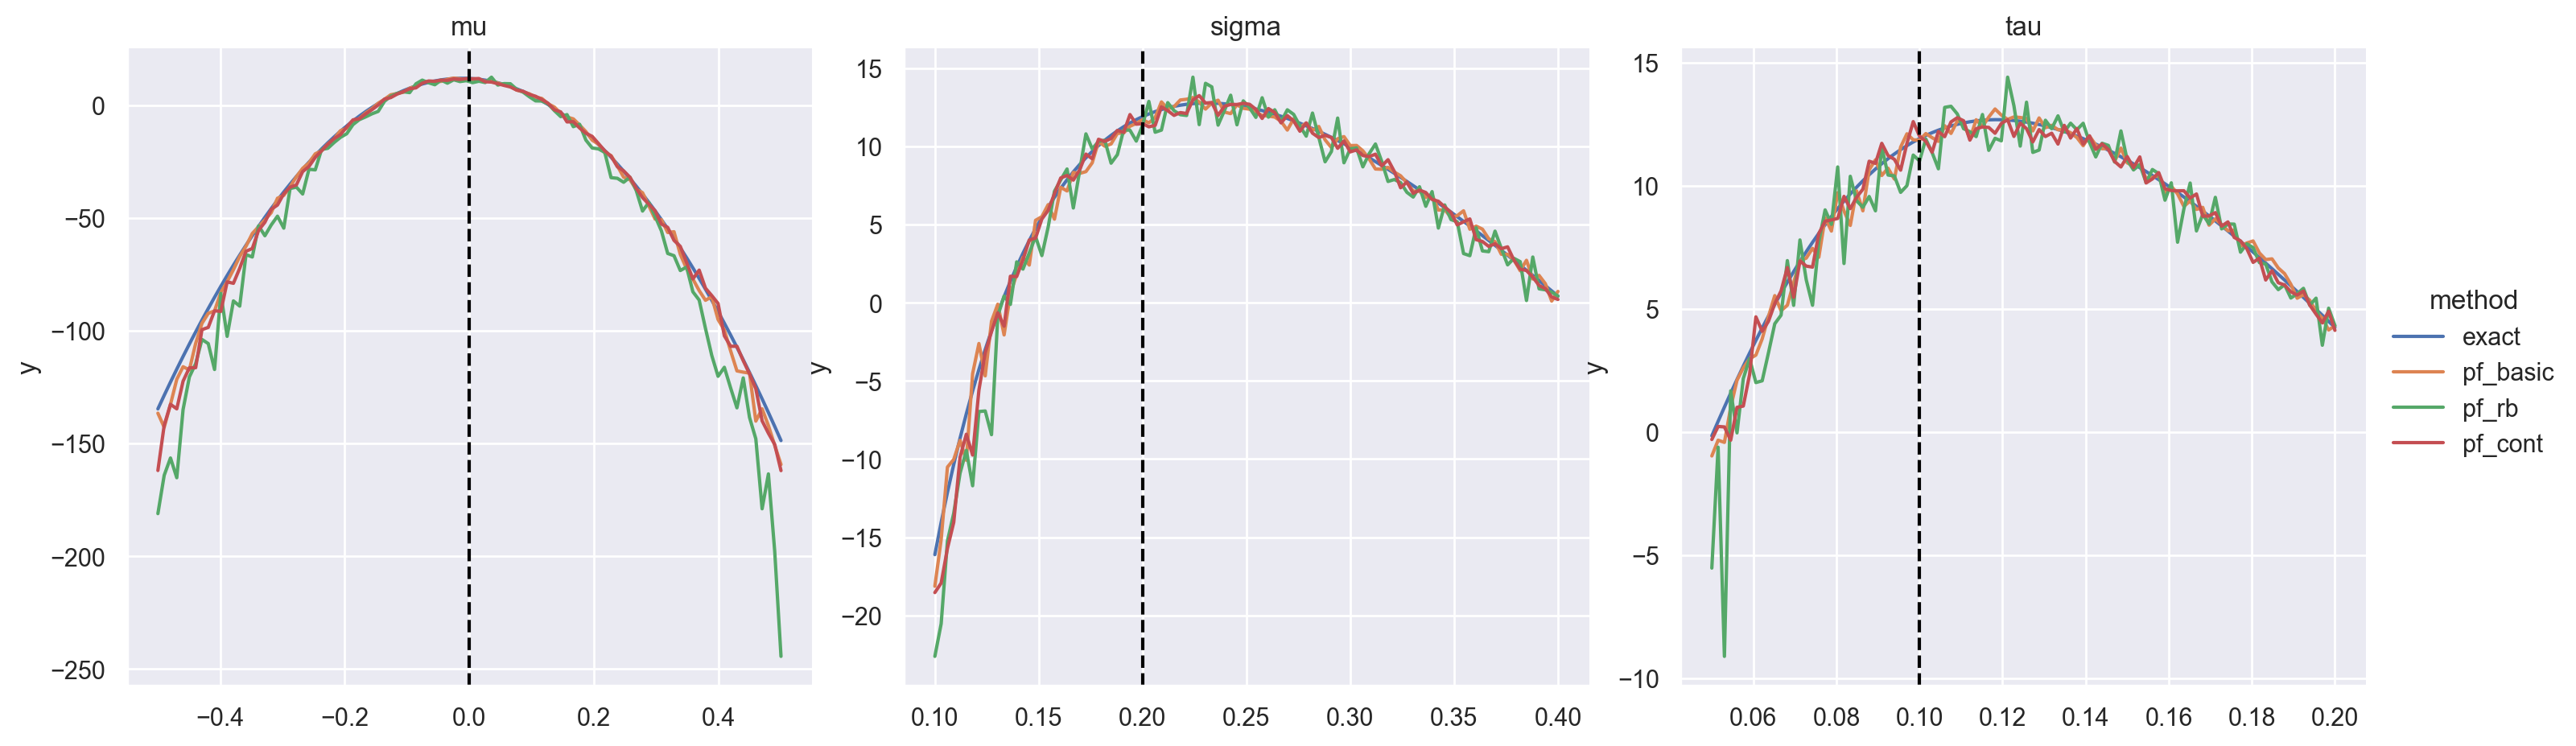

In [10]:
#merge data frames and plot them
plot_df = pd.concat([df_exact, df_basic, df_rb, df_cont], ignore_index=True)
plot_df["method"] = np.repeat(["exact", "pf_basic", "pf_rb", "pf_cont"], len(df_exact["x_opt"]))
rp = sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", 
    hue="method",
    col="x_opt",
    col_wrap = 3,
    facet_kws=dict(sharex=False, sharey=False)
)
rp.set_titles(col_template="{col_name}")
rp.set(xlabel=None)
# add true parameter values
for ax, theta in zip(rp.axes.flat, theta_true):
    ax.axvline(theta, linestyle="--", color="black")

### Check Particle Filter Approximations

In [11]:
import pfjax.experimental as pfex

def to_phi(theta):
    """
    Helper function to convert theta to phi.
    """
    return jnp.array([theta[0], jnp.log(theta[1]), jnp.log(theta[2])])

def to_theta(phi):
    """
    Helper function to convert phi to theta.
    """
    return jnp.array([phi[0], jnp.exp(phi[1]), jnp.exp(phi[2])])

def prop_lpdf(self, x_curr, x_prev, y_curr, theta):
    """
    Add proposal log-pdf to bm_model.
    """
    return self.state_lpdf(x_curr=x_curr, x_prev=x_prev, theta=theta)

def bm_loglik_exact(theta, y_meas):
    """
    Exact loglikelihood of the BM model.
    """
    return bm_model.loglik_exact(y_meas=y_meas, theta=theta)

def bm_loglik_stan(theta, y_meas, key, n_particles, resampler = pf.particle_resamplers.resample_multinomial):
    """
    Standard particle filter approximation of the loglikelihood.
    """
    pf_out = pfex.particle_filter(
        model=bm_model,
        key=key,
        y_meas=y_meas,
        theta=theta,
        resampler = resampler,
        n_particles=n_particles,
        history=False
    )
    return pf_out["loglik"]

def bm_loglik_rb(theta, y_meas, key, n_particles):
    """
    Rao-Blackwellized particle filter approximation of the negative loglikelihood.
    """
    pf_out = pfex.particle_filter_rb(
        model=bm_model,
        key=key,
        y_meas=y_meas,
        theta=theta,
        n_particles=n_particles,
        history=False
    )
    return pf_out["loglik"]

def bm_loglik_cont(theta, y_meas, key, n_particles):
    """
    Rao-Blackwellized particle filter approximation of the negative loglikelihood.
    """
    pf_out = pfex.particle_filter_rb(
        model=bm_model,
        key=key,
        y_meas=y_meas,
        theta=theta,
        resampler=resample_continuous_bm,
        n_particles=n_particles,
        history=False
    )
    return pf_out["loglik"]

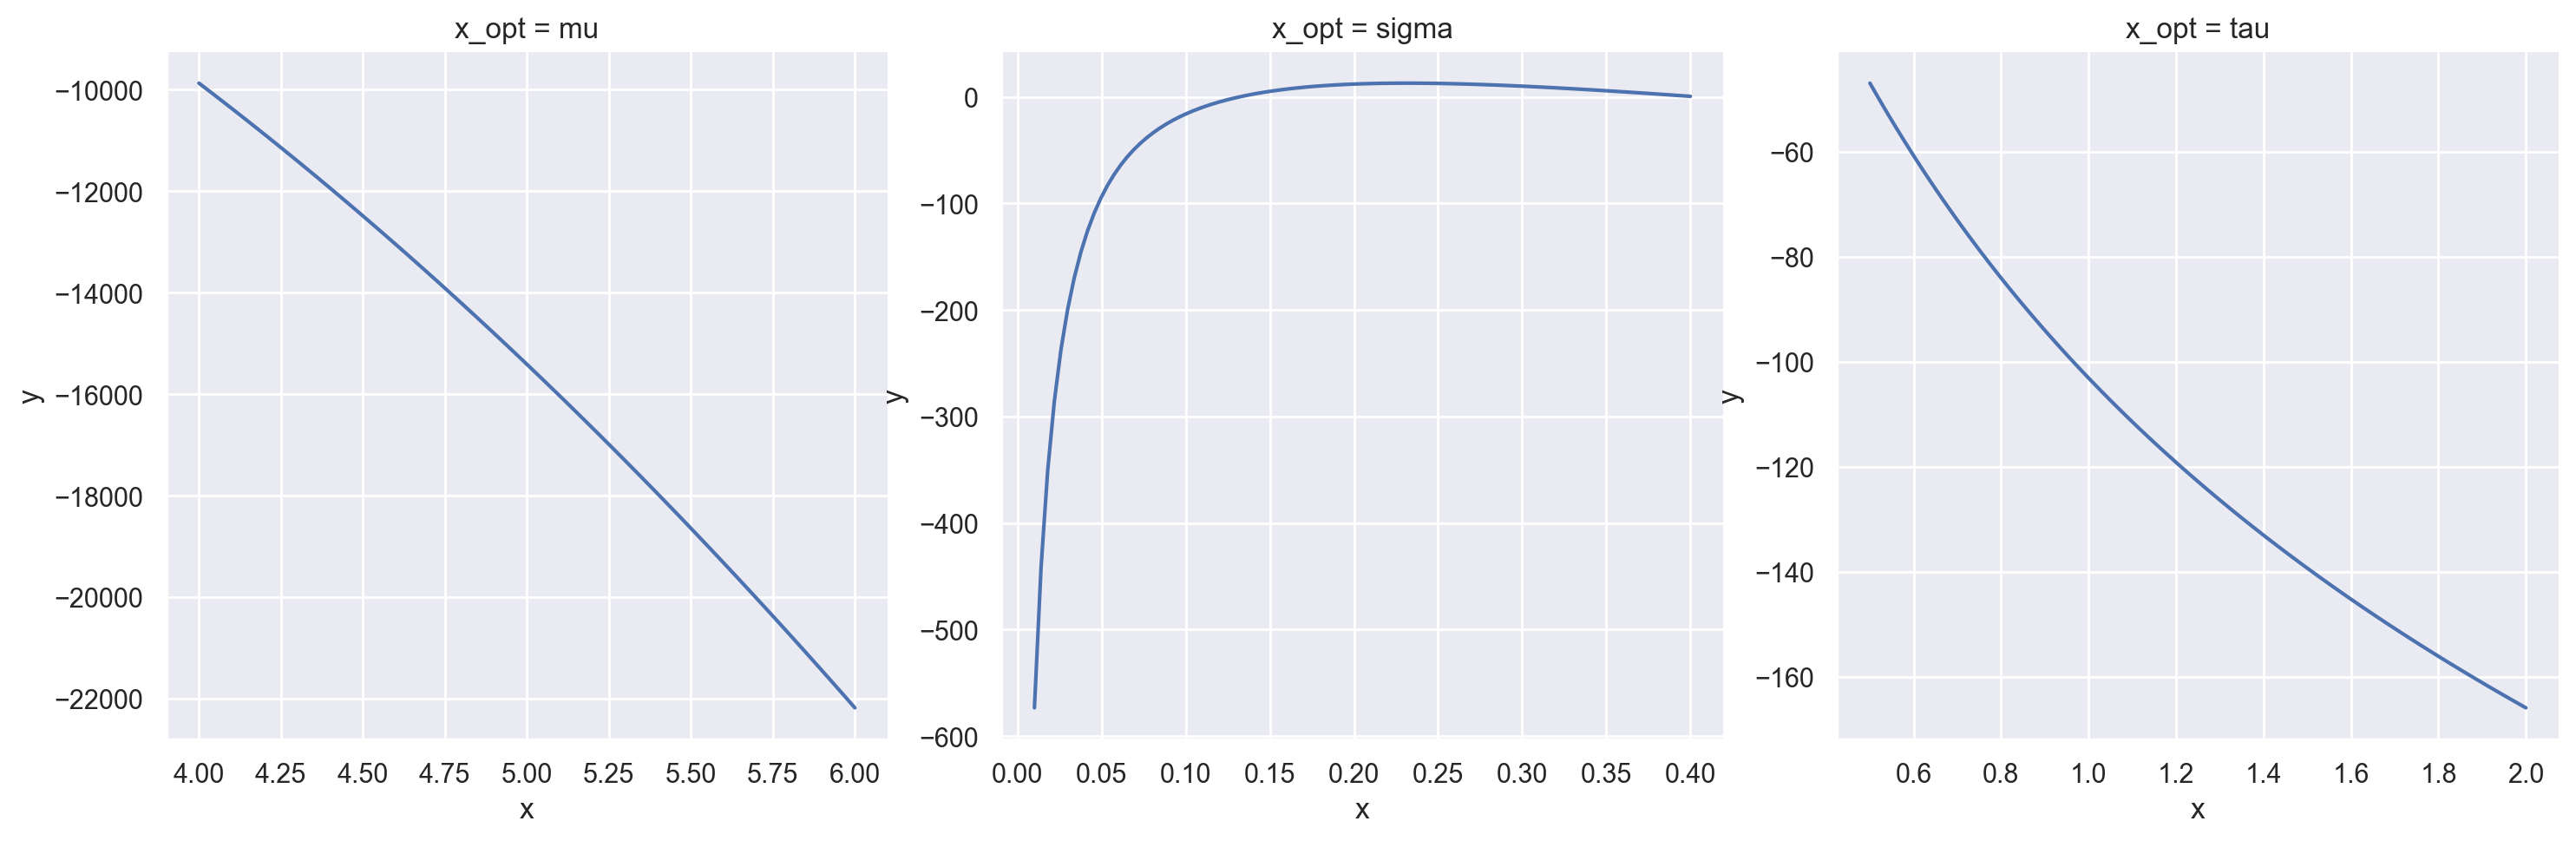

In [12]:
def proj_data(fun, x, x_lims, x_names, n_pts=100):
    """
    Wrapper for `projplot.projxvals()` and `projplot.projdata()`.

    Won't need this for upcoming interface of projplot.
    """
    xvals = pjp.proj_xvals(x, x_lims, n_pts)
    return pjp.proj_data(fun, xvals, x_names) #, is_vectorized=False)


# plot exact likelihood
theta_lims = jnp.array([[4., 6.], [.01, .4], [.5, 2]])  # for n_obs = 100

theta_names = ["mu", "sigma", "tau"]
n_pts = 100

# calculate projection plot
df_exact = pjp.proj_plot(
    fun=jax.jit(partial(bm_loglik_exact, y_meas=y_meas)),
    x_opt=theta_true, 
    x_lims=theta_lims, 
    x_names=theta_names, 
    n_pts=n_pts,
    plot = True
)

41.7 ms ± 2.52 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


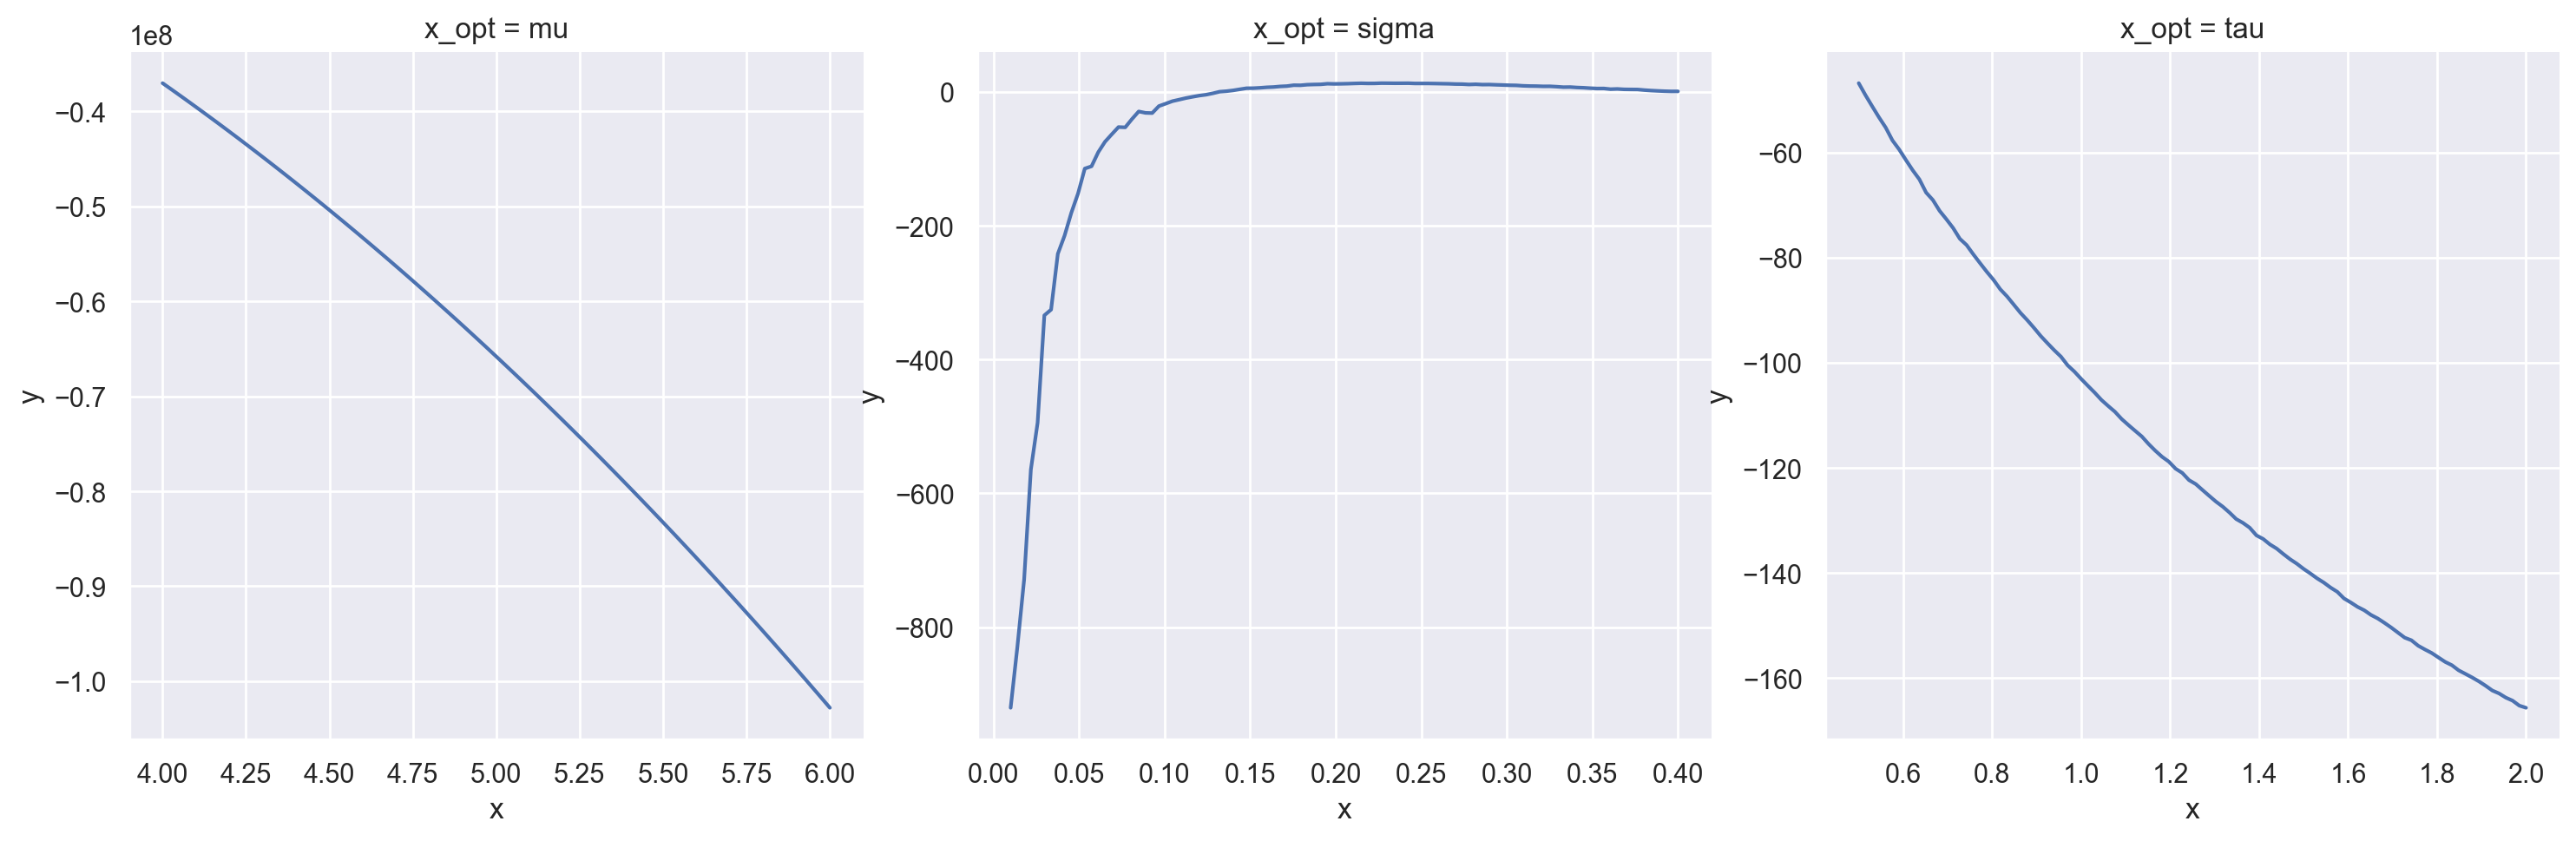

In [13]:
# standard particle filter (multinomial resampling)

n_particles_stan = 2500

key, subkey = random.split(key)
bm_ll_stan = jax.jit(partial(bm_loglik_stan, y_meas=y_meas,
                             n_particles=n_particles_stan, key=subkey))

%timeit bm_ll_stan(theta_true)

# calculate projection plot
df_stan = pjp.proj_plot(
    fun=bm_ll_stan,
    x_opt=theta_true, 
    x_lims=theta_lims, 
    x_names=theta_names, 
    n_pts=n_pts,
    plot = True
)

18.3 ms ± 784 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


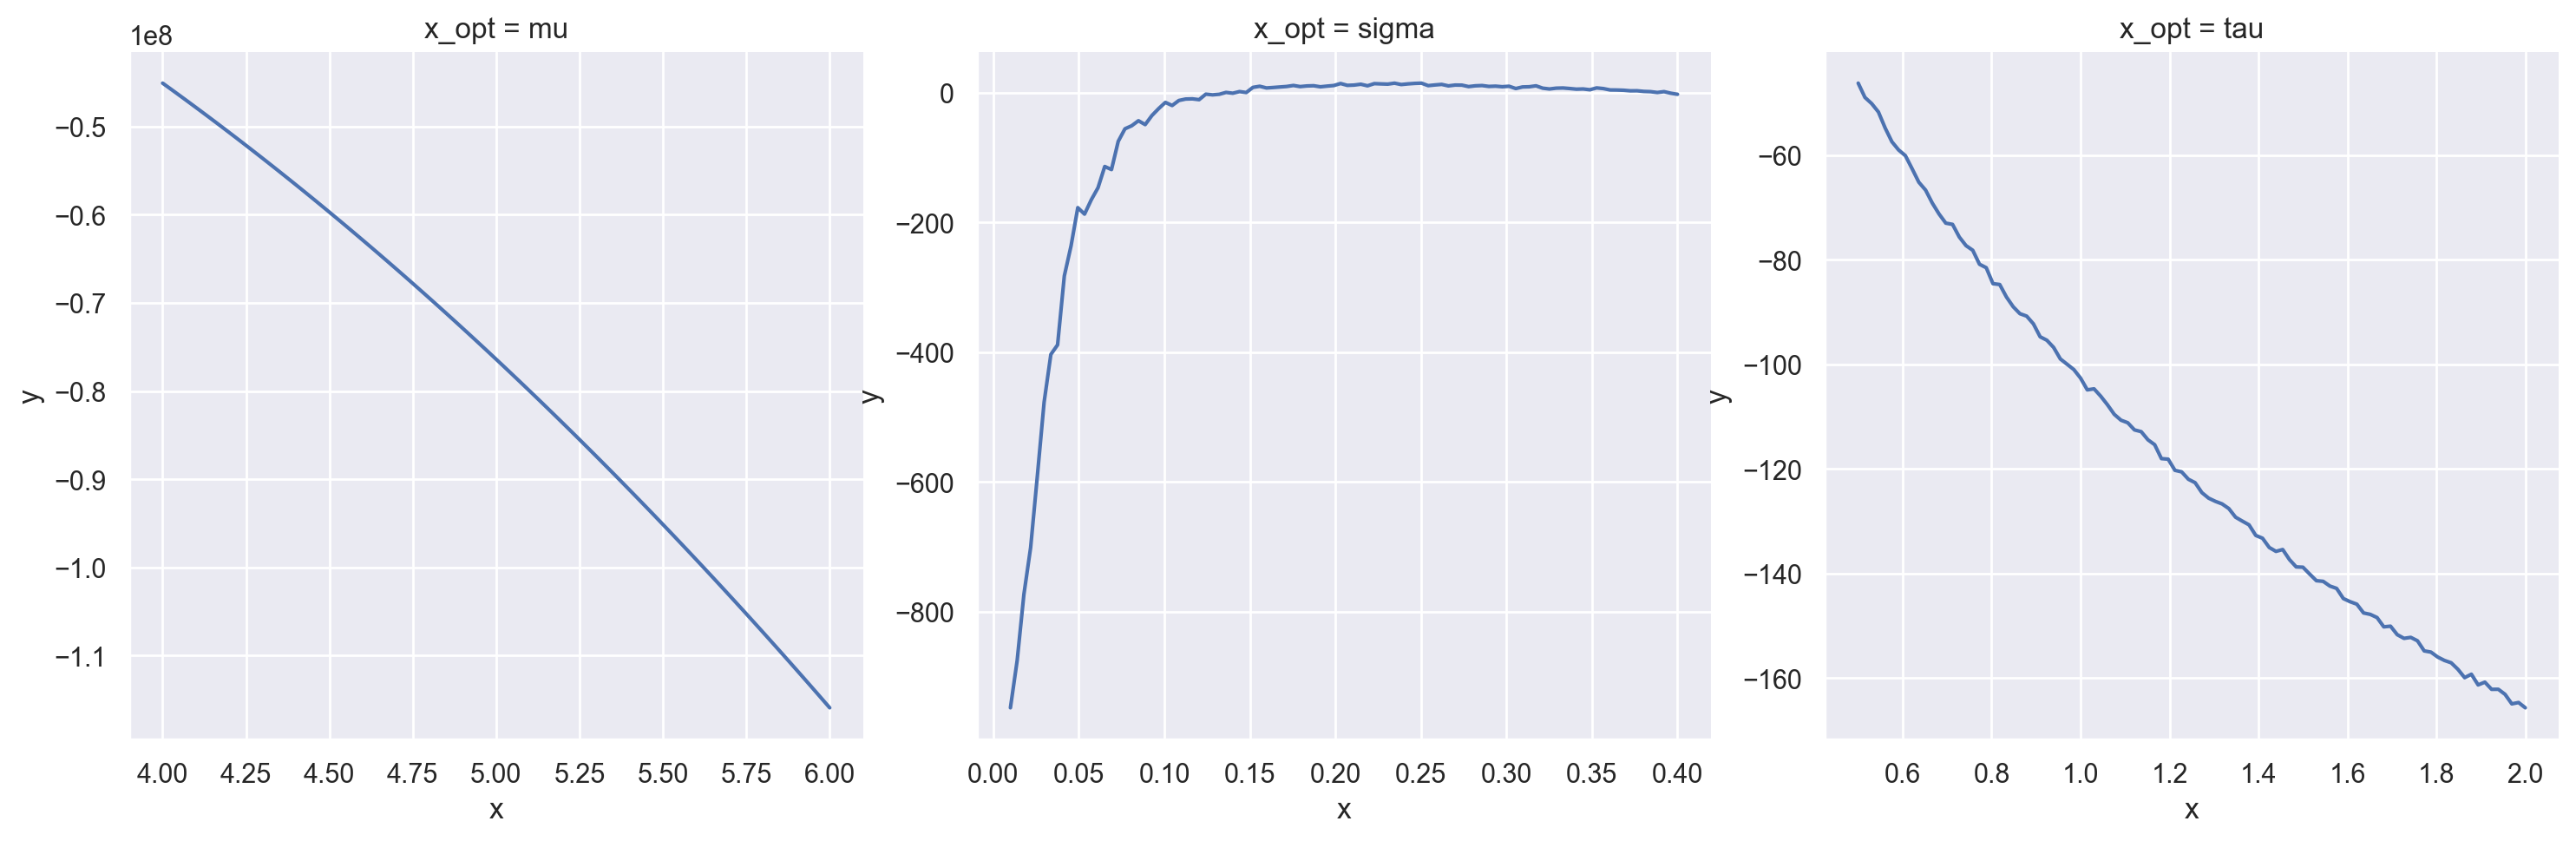

In [14]:
# rao-blackwellized particle filter

n_particles_rb = 100

key, subkey = random.split(key)
bm_ll_rb = jax.jit(partial(bm_loglik_rb, y_meas=y_meas,
                             n_particles=n_particles_rb, key=subkey))

%timeit bm_ll_rb(theta_true)

# calculate projection plot
df_rb = pjp.proj_plot(
    fun=bm_ll_rb,
    x_opt=theta_true, 
    x_lims=theta_lims, 
    x_names=theta_names, 
    n_pts=n_pts,
    plot = True
)

195 ms ± 1.73 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


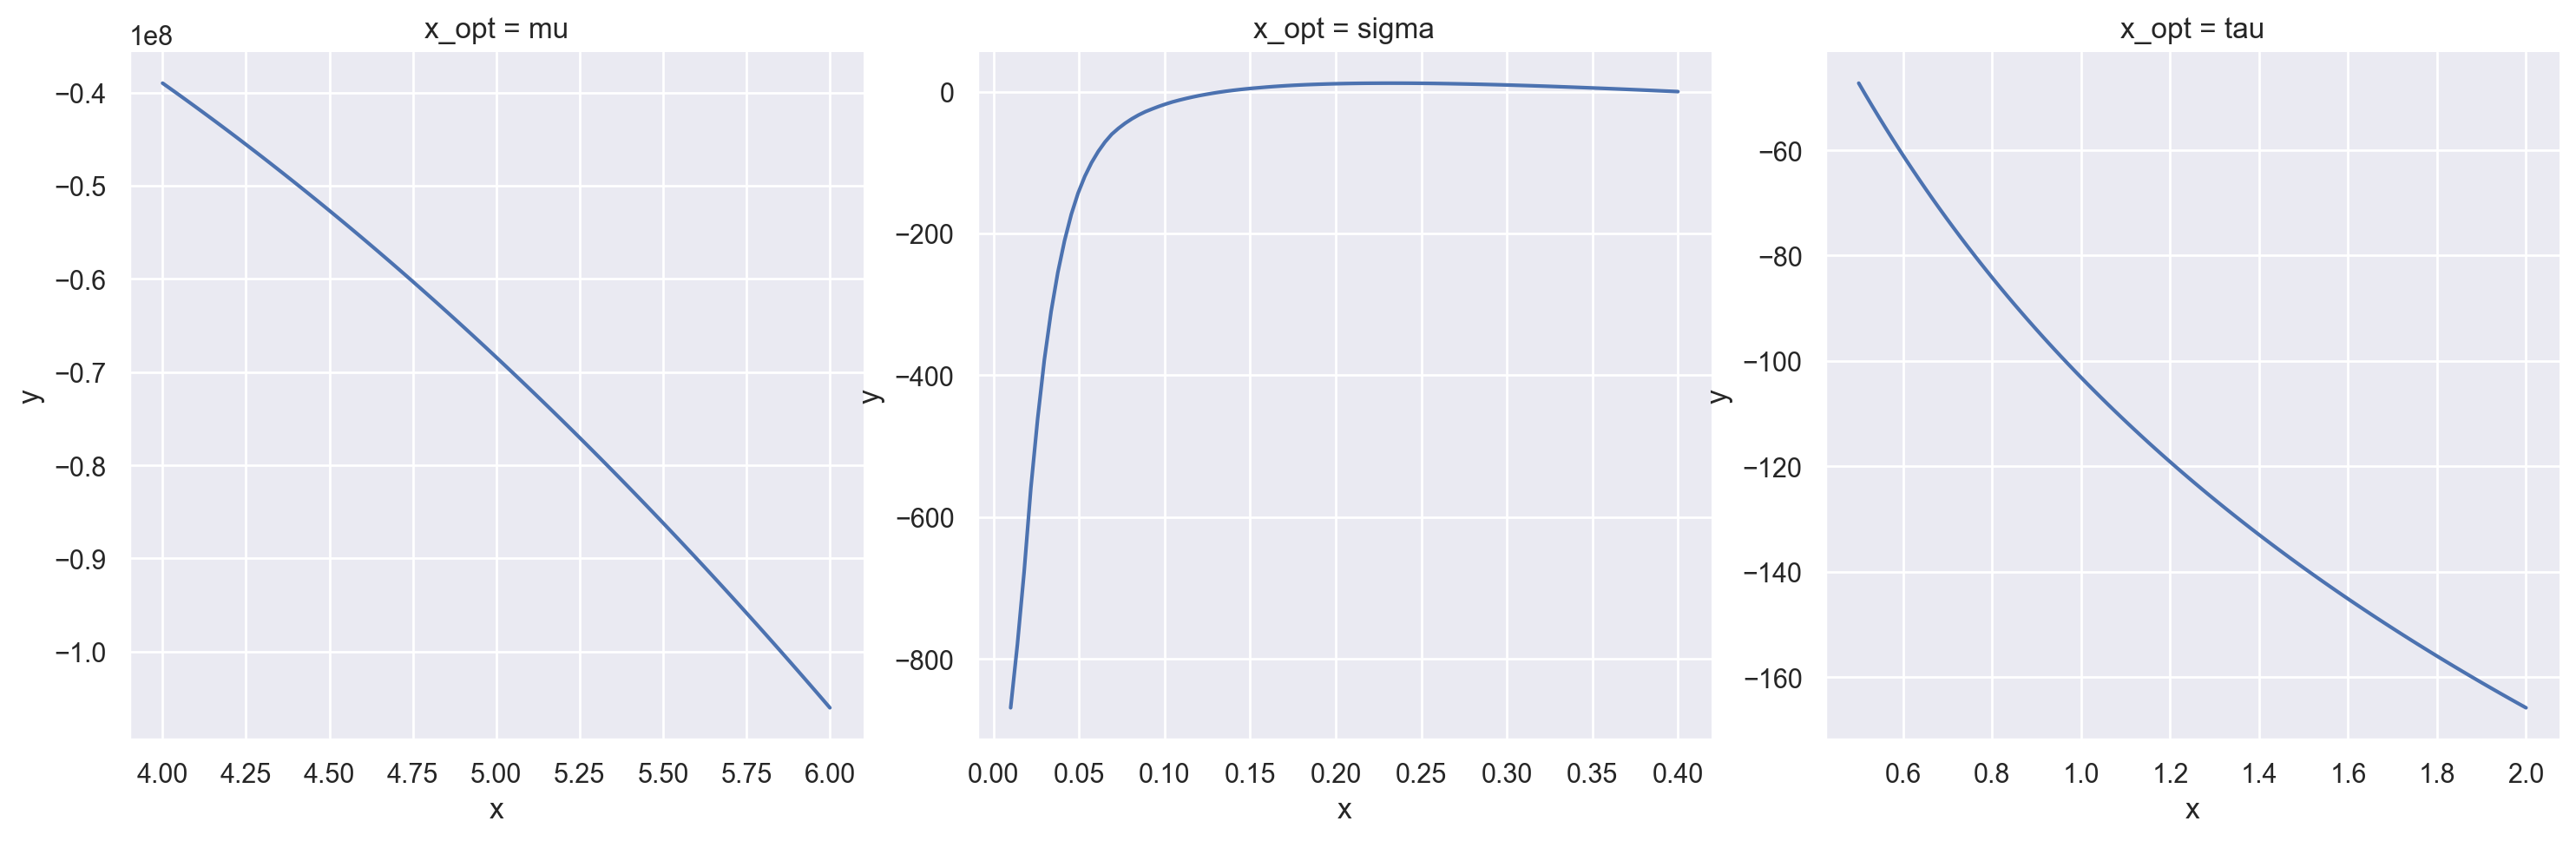

In [15]:
# continuous-cdf particle filter
n_particles_cont = 1000

key, subkey = random.split(key)
bm_ll_cont = jax.jit(partial(bm_loglik_stan, y_meas=y_meas, resampler=resample_continuous_bm,
                             n_particles=n_particles_cont, key=subkey))

%timeit bm_ll_cont(theta_true)

# calculate projection plot
df_cont = pjp.proj_plot(
    fun=bm_ll_cont,
    x_opt=theta_true, 
    x_lims=theta_lims, 
    x_names=theta_names, 
    n_pts=n_pts,
    plot = True
)

## Check Score Function

Here we'll compare three different approximations:

1.  Automatic differentiation through the standard particle filter.  This is know to produce biased results (\cite{corenflos_etal21}).

2.  A modification of the standard particle filter developed by \cite{cappe_moulines05} of which the bi-product is the score.  This algorithm is unbiased and scales as $\bO(NT)$, but we have $\var(\widehat{\nabla \ell}_N(\tth)) = \bO{T^2/N}$ (\cite{poyiadjis_etal11}).

3.  A bi-product of the Rao-Blackwellized particle filter developped by \cite{poyiadjis_etal11}.

For simplicity we'll just check the various approximations at the true value of $\tth$.

In [16]:
# various score functions
bm_score_exact = jax.jit(jax.grad(partial(bm_loglik_exact, y_meas=y_meas)))

@partial(jax.jit, static_argnums=(2,))
def bm_score_auto(theta, key, n_particles):
    return jax.grad(bm_loglik_stan)(theta, y_meas, key, n_particles)


@partial(jax.jit, static_argnums=(2,))
def bm_score_acc(theta, key, n_particles):
    out = pfex.particle_filter(
        model=bm_model,
        key=key,
        y_meas=y_meas,
        theta=theta,
        n_particles=n_particles,
        score=True,
        fisher=False,
        history=False
    )
    return out["score"]


@partial(jax.jit, static_argnums=(2,))
def bm_score_rb(theta, key, n_particles): 
    out = pfex.particle_filter_rb(
        model=bm_model,
        key=key,
        y_meas=y_meas,
        theta=theta,
        n_particles=n_particles,
        score=True,
        fisher=False,
        history=False
    )
    return out["score"]


@partial(jax.jit, static_argnums=(2,))
def bm_score_cont(theta, key, n_particles): 
    out = pfex.particle_filter_rb(
        model=bm_model,
        key=key,
        y_meas=y_meas,
        theta=theta,
        resampler = resample_continuous_bm,
        n_particles=n_particles,
        score=True,
        fisher=False,
        history=False
    )
    return out["score"]

In [17]:
key = random.PRNGKey(0)
n_particles_stan = 2500
n_particles_rb = 100
n_sim = 100
n_particles_cont = 500
key, *subkeys = random.split(key, n_sim+1)

# check timings
%timeit bm_score_auto(theta_true, key, n_particles_stan)
%timeit bm_score_acc(theta_true, key, n_particles_stan)
%timeit bm_score_rb(theta_true, key, n_particles_rb)
%timeit bm_score_cont(theta_true, key, n_particles_cont)

51.8 ms ± 1.89 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
45 ms ± 2.44 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
37.3 ms ± 500 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
632 ms ± 71.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
# repeat calculation nsim times
score_exact = bm_score_exact(theta_true)
score_auto = []
score_acc = []
score_rb = []
score_cont = []

for i in range(n_sim):
    score_auto += [bm_score_auto(theta_true, subkeys[i], n_particles_stan)]
    score_acc += [bm_score_acc(theta_true, subkeys[i], n_particles_stan)]
    score_rb += [bm_score_rb(theta_true, subkeys[i], n_particles_rb)]
    score_cont += [bm_score_cont(theta_true, subkeys[i], n_particles_cont)]

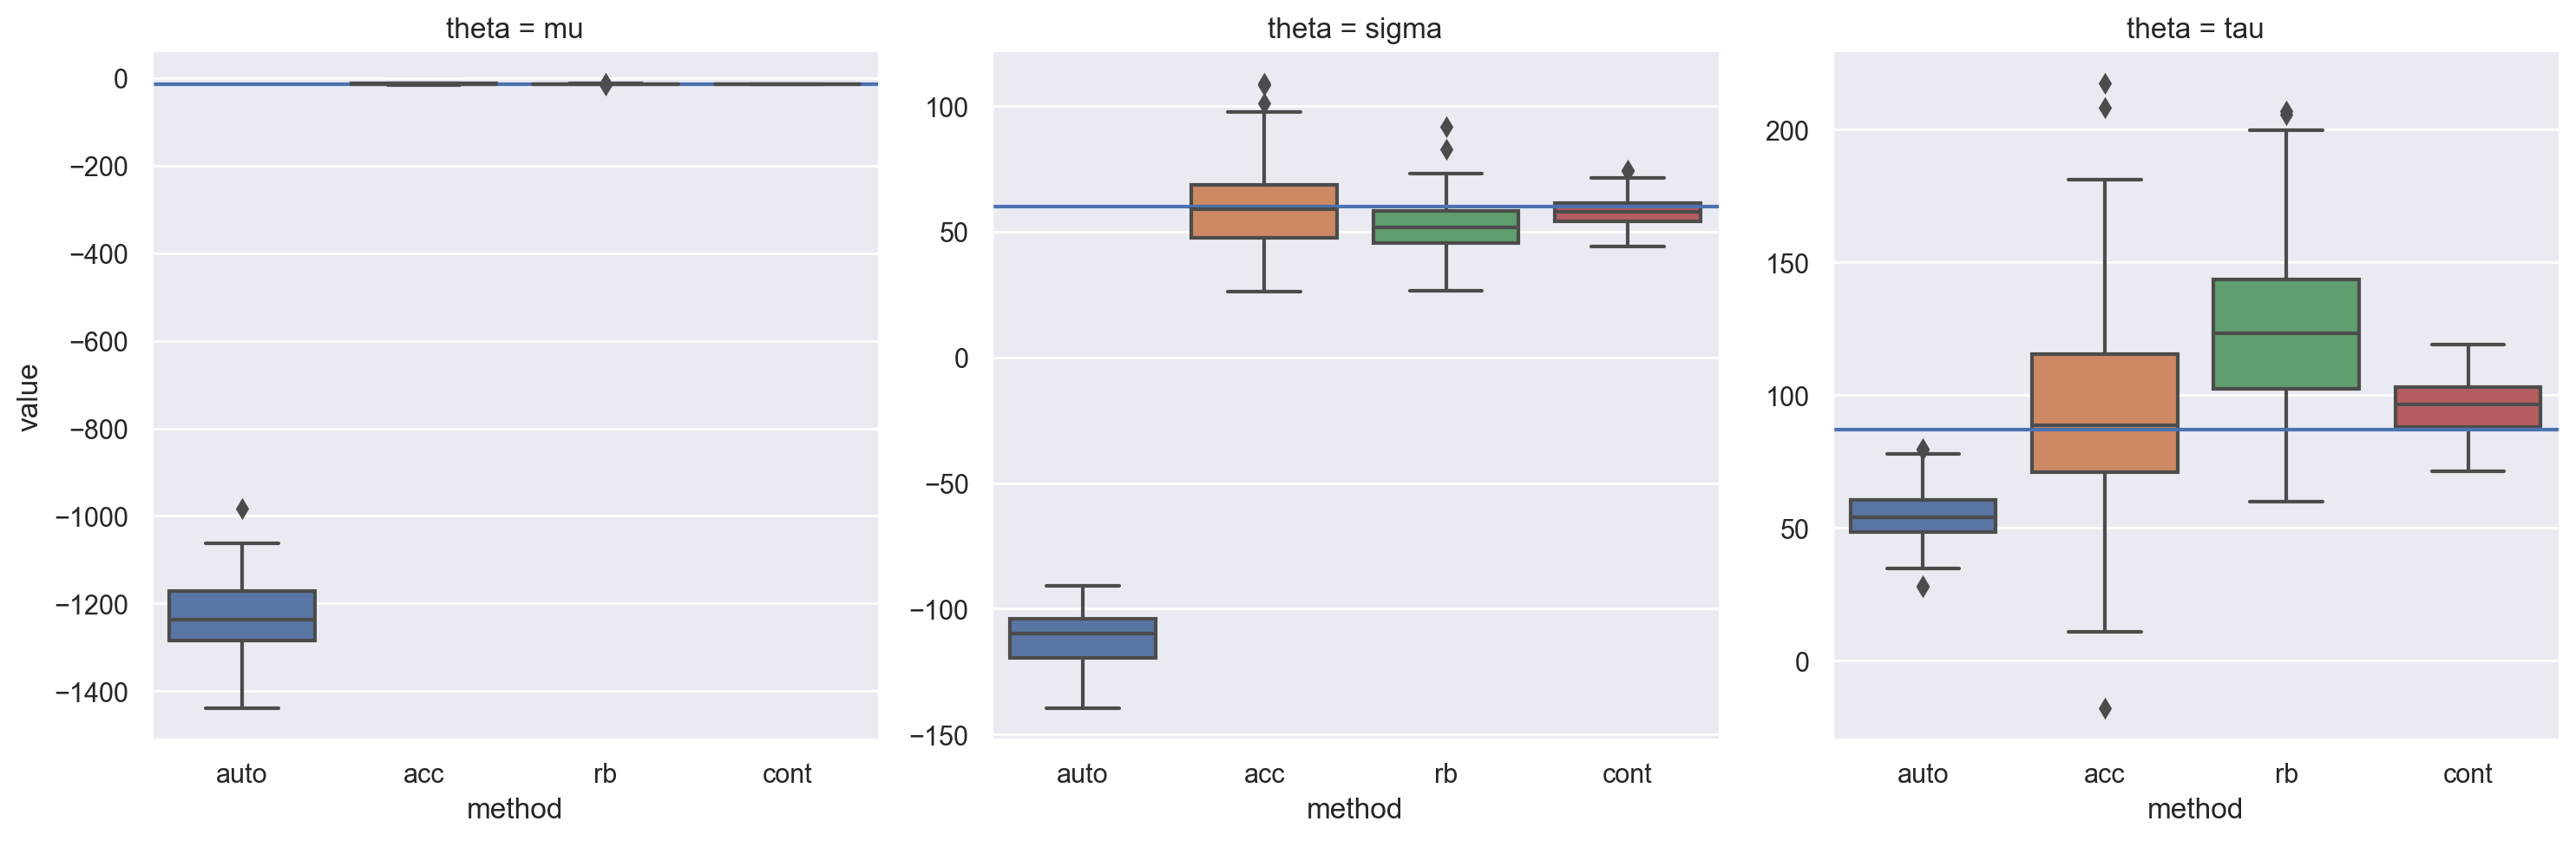

In [19]:
plot_df = (
    pd.DataFrame({
    "theta": np.tile(theta_names, n_sim),
    "auto": np.array(score_auto).ravel(),
    "acc": np.array(score_acc).ravel(),
    "rb": np.array(score_rb).ravel(),
    "cont": np.array(score_cont).ravel()
})
    .melt(id_vars=["theta"], value_vars=["auto", "acc", "rb", "cont"], var_name="method")
)

g = sns.catplot(
    data=plot_df, kind="box",
    x="method", y="value",
    col="theta",
    col_wrap=3,
    sharey=False
)
[g.axes[i].axhline(score_exact[i]) for i in range(theta_true.size)];

## Compare Score Functions for Resamplers

- [ ] Compare bias in score function for different resampling methods. Only change the resampling scheme used and calculate the score function using autograd

In [45]:
# score function for different resampling schemes: 
def bm_loglik(theta, y_meas, key, n_particles, resampler = pf.particle_resamplers.resample_multinomial):
    """
    Standard particle filter approximation of the loglikelihood.
    """
    pf_out = pfex.particle_filter(
        model=bm_model,
        key=key,
        y_meas=y_meas,
        theta=theta,
        resampler = resampler,
        n_particles=n_particles,
        history=False
    )
    return pf_out["loglik"]

# multinomial resampling:
@partial(jax.jit, static_argnums=(2,))
def bm_score_multinom(theta, key, n_particles):
    return jax.grad(bm_loglik)(theta, y_meas, key, n_particles)

# MVN resampling: 
@partial(jax.jit, static_argnums=(2,))
def bm_score_mvn(theta, key, n_particles):
    return jax.grad(bm_loglik)(theta, y_meas, key, n_particles, resampler = pf.particle_resamplers.resample_mvn)

# continuous CDF resampling: 
@partial(jax.jit, static_argnums=(2,))
def bm_score_cont(theta, key, n_particles):
    return jax.grad(bm_loglik)(theta, y_meas, key, n_particles, 
                               resampler = resample_continuous_bm)

In [48]:
key = random.PRNGKey(0)
n_particles = 2500
n_sim = 100
key, *subkeys = random.split(key, n_sim+1)

# repeat calculation nsim times
score_multinom = []
score_mvn = []
score_cont = []

for i in range(n_sim):
    score_multinom += [bm_score_multinom(theta_true, subkeys[i], n_particles)]
    score_mvn += [bm_score_mvn(theta_true, subkeys[i], n_particles)]
    score_cont += [bm_score_cont(theta_true, subkeys[i], n_particles)]

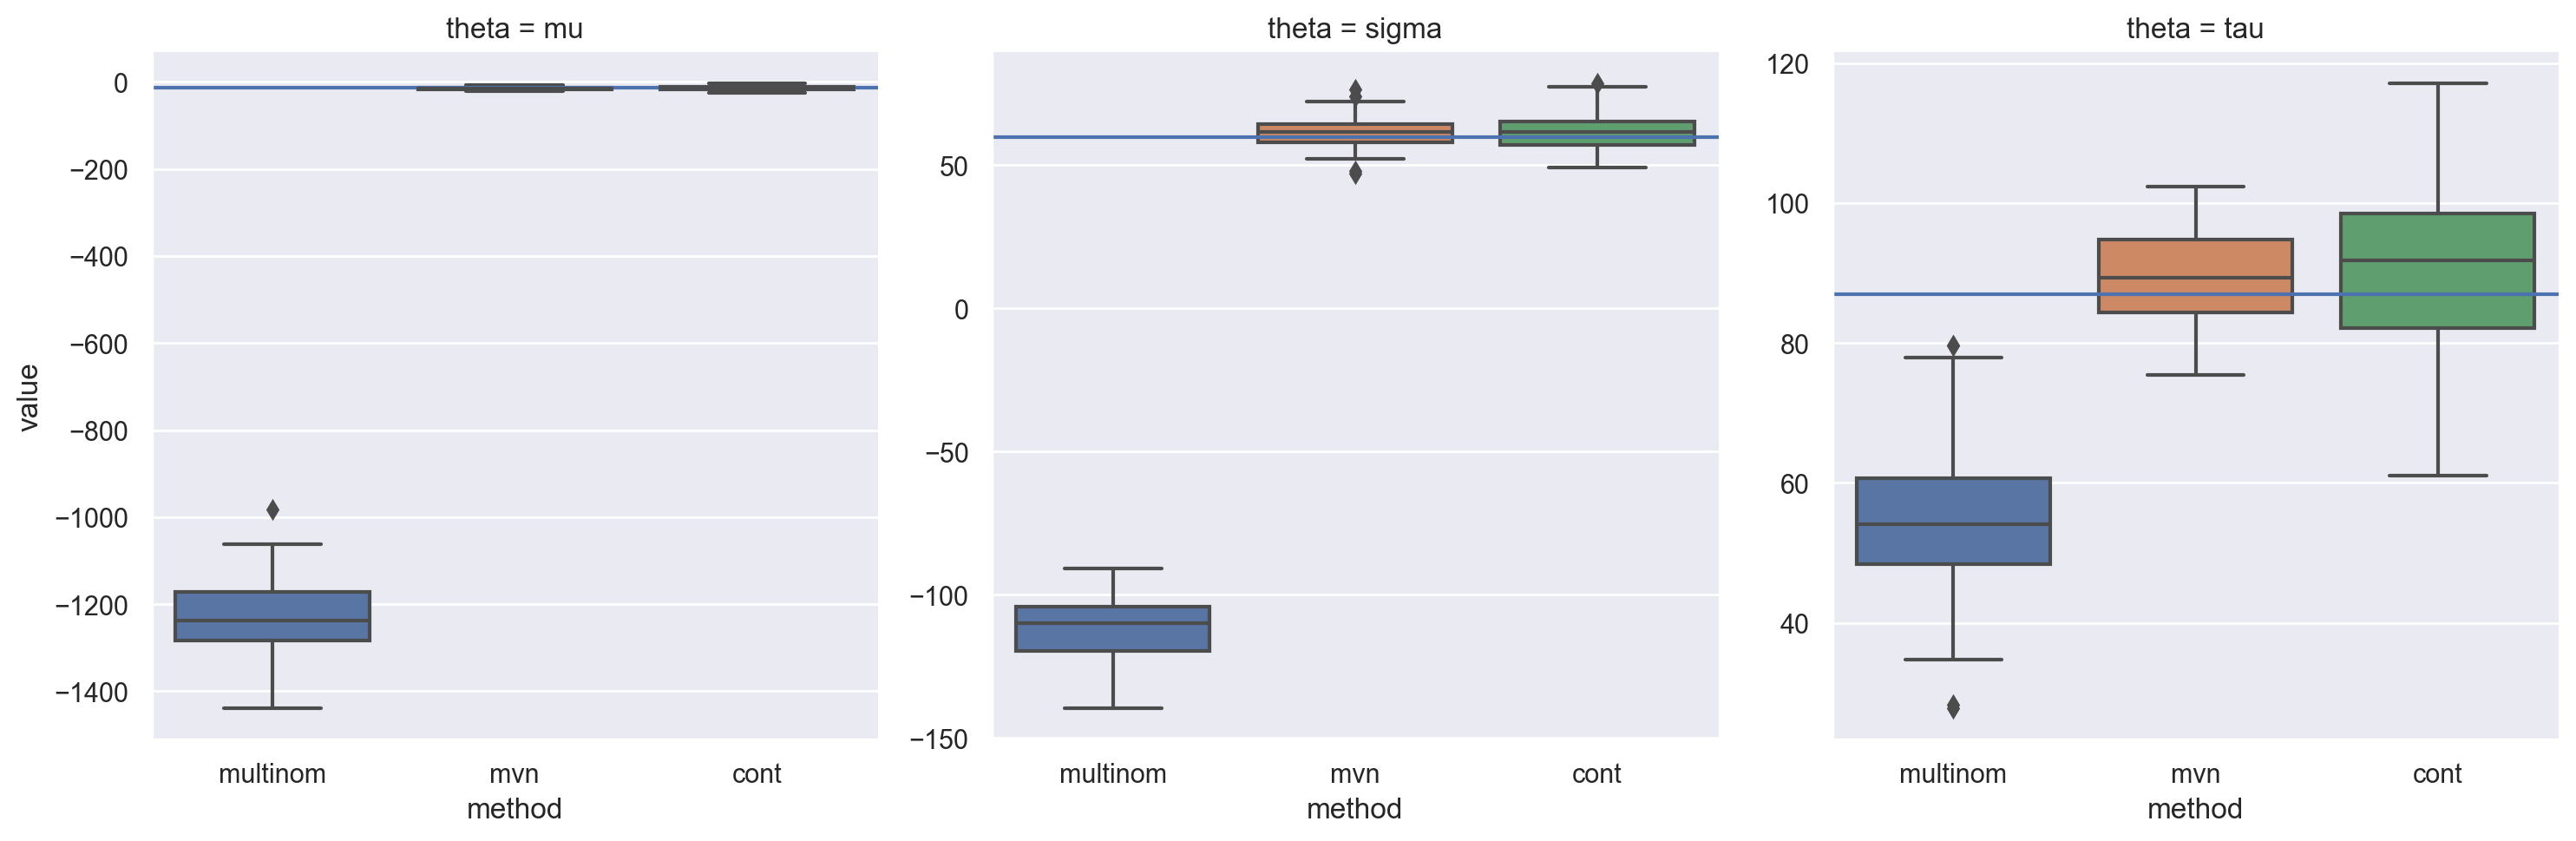

In [49]:
plot_df = (
    pd.DataFrame({
    "theta": np.tile(theta_names, n_sim),
    "multinom": np.array(score_multinom).ravel(),
    "mvn": np.array(score_mvn).ravel(),
    "cont": np.array(score_cont).ravel()
})
    .melt(id_vars=["theta"], value_vars=["multinom", "mvn", "cont"], var_name="method")
)

g = sns.catplot(
    data=plot_df, kind="box",
    x="method", y="value",
    col="theta",
    col_wrap=3,
    sharey=False
)
[g.axes[i].axhline(score_exact[i]) for i in range(theta_true.size)];

### Compare Fisher Information

Compare Fisher information for different resampling methods using autograd

In [50]:
# multinomial resampling:
@partial(jax.jit, static_argnums=(2,))
def bm_fisher_multinom(theta, key, n_particles):
    return jax.jacfwd(jax.jacrev(bm_loglik))(theta, y_meas, key, n_particles)

# MVN resampling: 
@partial(jax.jit, static_argnums=(2,))
def bm_fisher_mvn(theta, key, n_particles):
    return jax.jacfwd(jax.jacrev(bm_loglik))(theta, y_meas, key, n_particles, 
                                             resampler = pf.particle_resamplers.resample_mvn)

# continuous CDF resampling: 
@partial(jax.jit, static_argnums=(2,))
def bm_fisher_cont(theta, key, n_particles):
    return jax.jacfwd(jax.jacrev(bm_loglik))(theta, y_meas, key, n_particles, 
                                             resampler = resample_continuous_bm)

In [57]:
key = random.PRNGKey(0)
n_particles = 2500
n_sim = 100
key, *subkeys = random.split(key, n_sim+1)

# repeat calculation nsim times
fisher_multinom = []
fisher_mvn = []
fisher_cont = []

for i in range(n_sim):
    fisher_multinom += [bm_fisher_multinom(theta_true, subkeys[i], n_particles)]
    fisher_mvn += [bm_fisher_mvn(theta_true, subkeys[i], n_particles)]
    fisher_cont += [bm_fisher_cont(theta_true, subkeys[i], n_particles)]

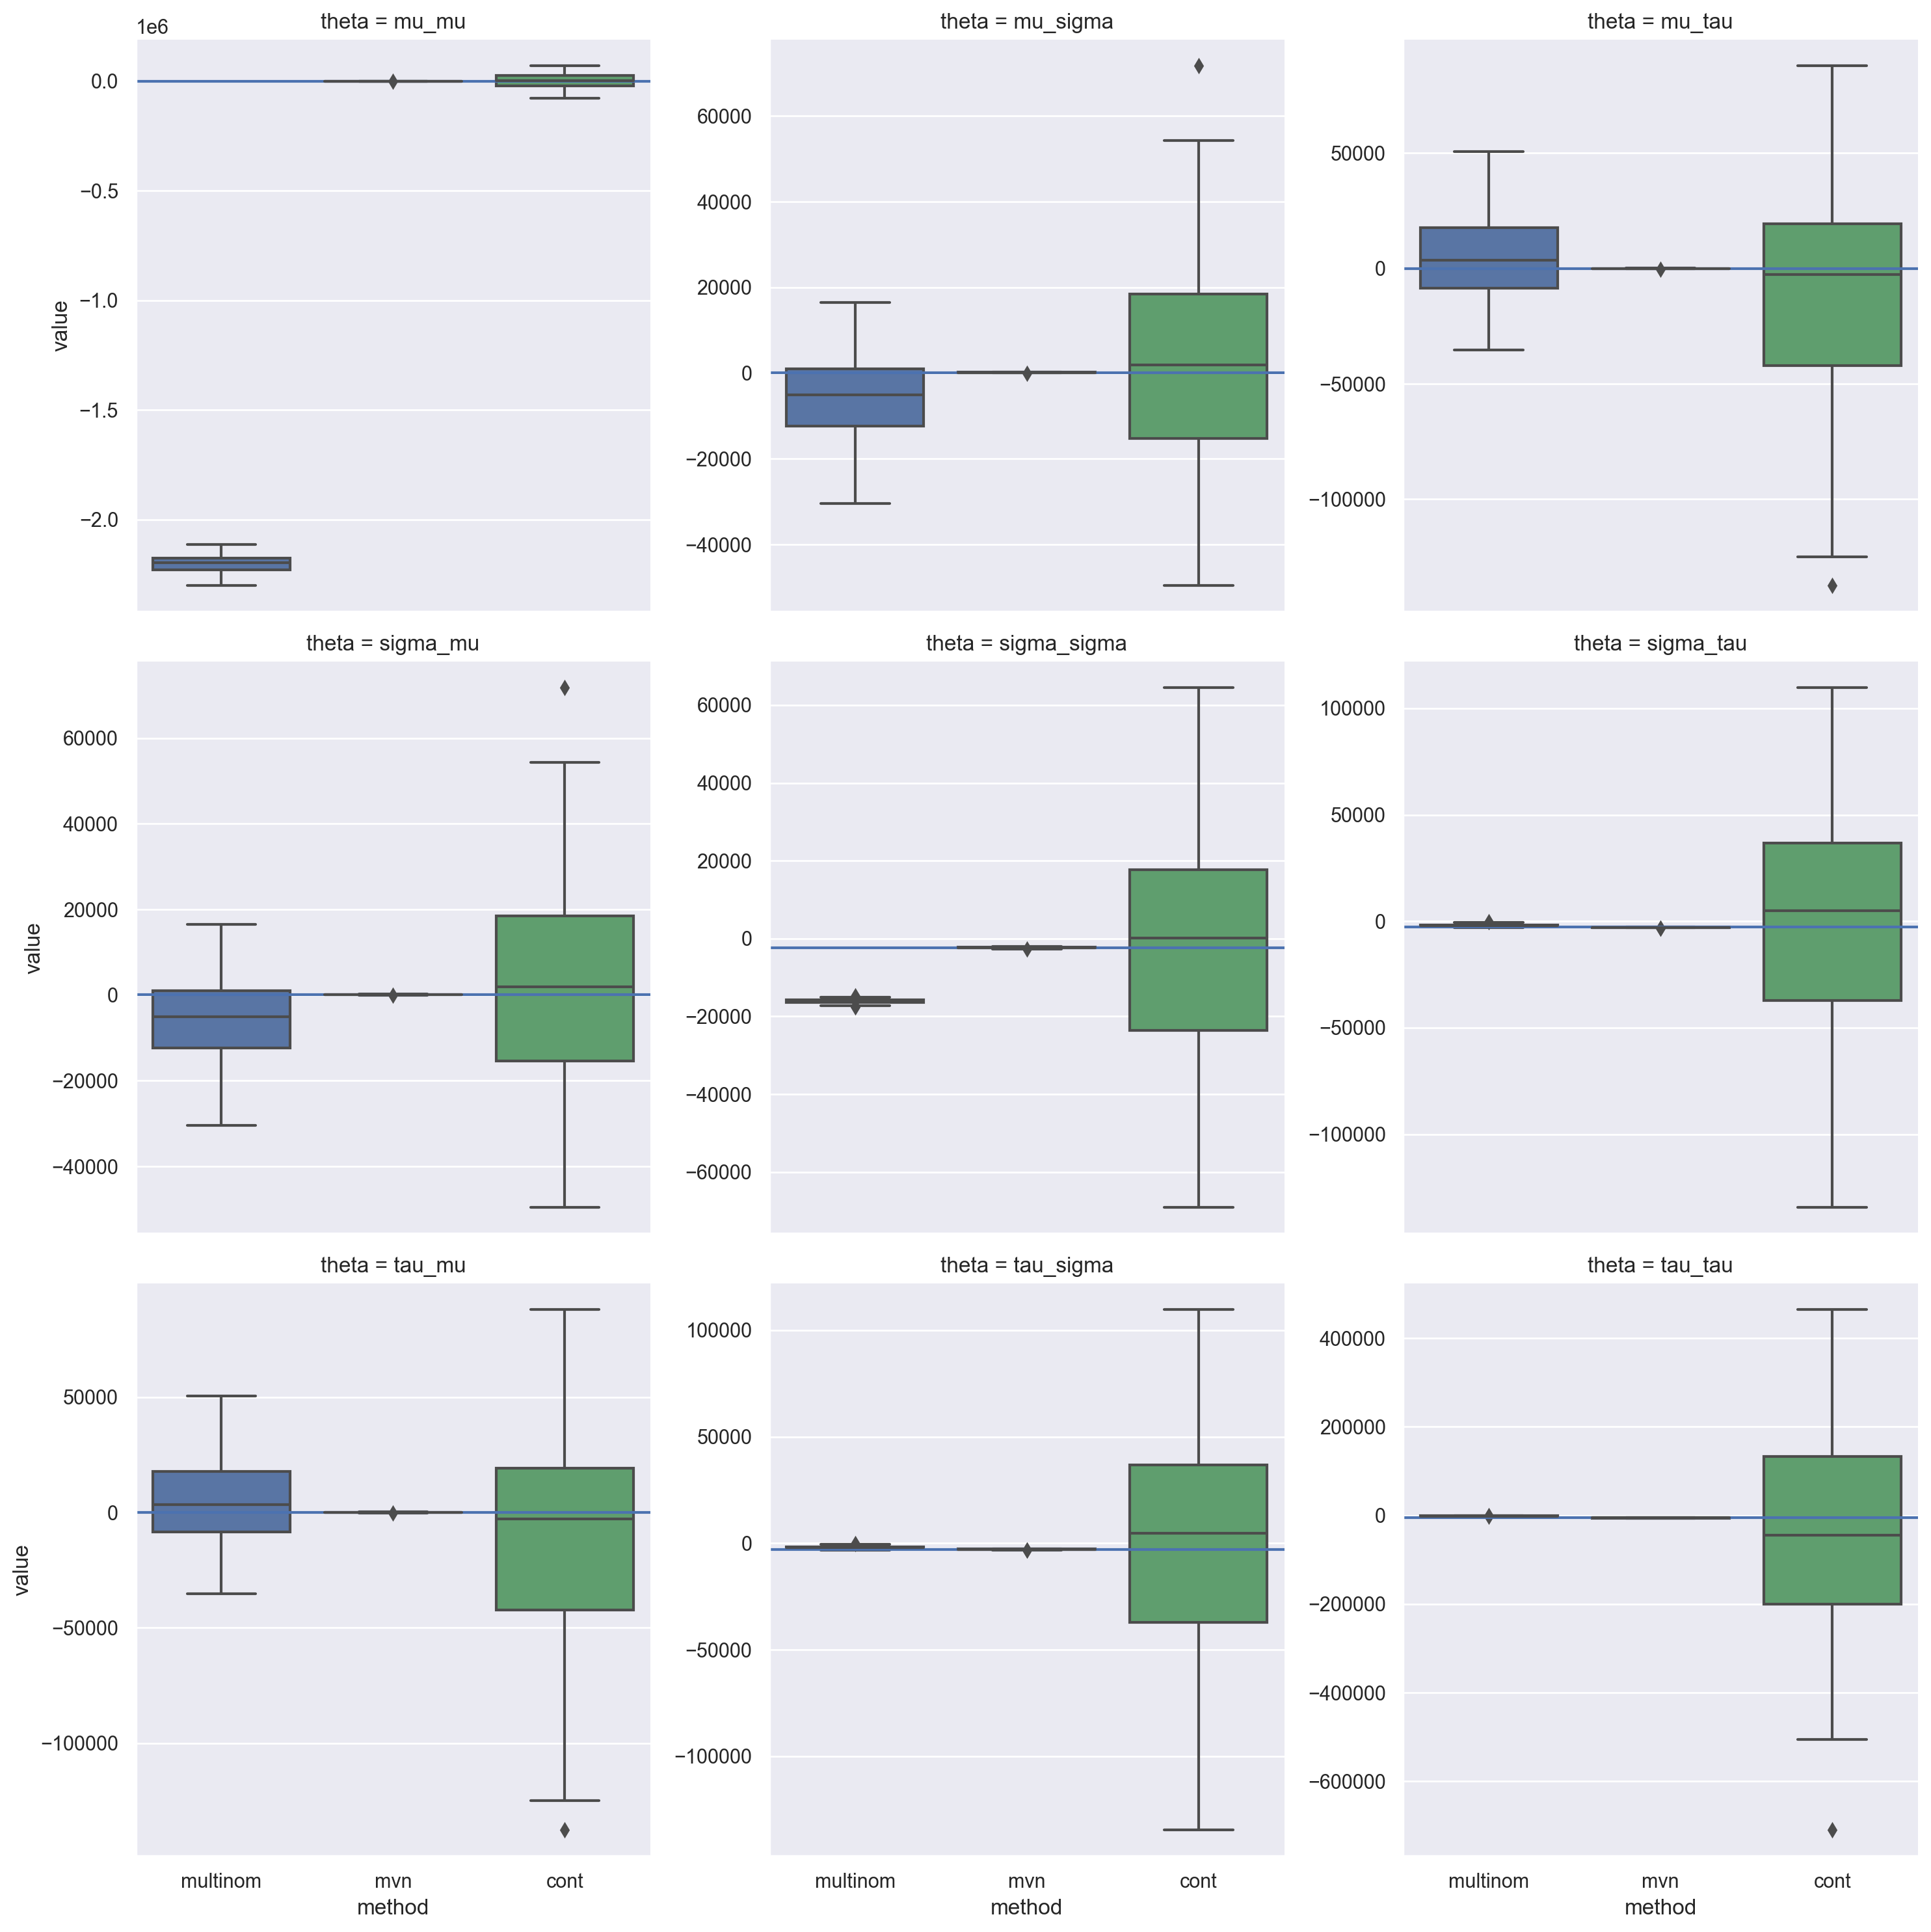

In [58]:
theta2_names = np.meshgrid(np.array(theta_names), np.array(theta_names))
theta2_names = np.array(
    [theta2_names[1].ravel()[i] + '_' +
     theta2_names[0].ravel()[i]
     for i in range(theta2_names[0].size)]
)

plot_df = (
    pd.DataFrame({
    "theta": np.tile(theta2_names, n_sim),
    "multinom": np.array(fisher_multinom).ravel(),
    "mvn": np.array(fisher_mvn).ravel(),
    "cont": np.array(fisher_cont).ravel()
})
    .melt(id_vars=["theta"], value_vars=["multinom", "mvn", "cont"], var_name="method")
)

g = sns.catplot(
    data=plot_df, kind="box",
    x="method", y="value",
    col="theta",
    col_wrap=3,
    sharey=False
)
[g.axes[i].axhline(fisher_exact.ravel()[i]) for i in range(theta2_names.size)];

## Check Fisher Information

In [21]:
# various fisher information calculations

bm_fisher_exact = jax.jit(
    jax.jacfwd(jax.jacrev(partial(bm_loglik_exact, y_meas=y_meas)))
)


@partial(jax.jit, static_argnums=(2,))
def bm_fisher_auto(theta, key, n_particles):
    return jax.jacfwd(jax.jacrev(bm_loglik_stan))(theta, y_meas, key, n_particles)


@partial(jax.jit, static_argnums=(2,))
def bm_fisher_acc(theta, key, n_particles):
    out = pfex.particle_filter(
        model=bm_model,
        key=key,
        y_meas=y_meas,
        theta=theta,
        n_particles=n_particles,
        score=True,
        fisher=True,
        history=False
    )
    return out["fisher"]


@partial(jax.jit, static_argnums=(2,))
def bm_fisher_rb(theta, key, n_particles):
    out = pfex.particle_filter_rb(
        model=bm_model,
        key=key,
        y_meas=y_meas,
        theta=theta,
        n_particles=n_particles,
        score=True,
        fisher=True,
        history=False
    )
    return out["fisher"]


@partial(jax.jit, static_argnums=(2,))
def bm_fisher_cont(theta, key, n_particles): 
    out = pfex.particle_filter_rb(
        model=bm_model,
        key=key,
        y_meas=y_meas,
        theta=theta,
        resampler = resample_continuous_bm,
        n_particles=n_particles,
        score=True,
        fisher=True,
        history=False
    )
    return out["fisher"]

In [22]:
key = random.PRNGKey(0)
n_particles_stan = 2500
n_particles_rb = 100
n_sim = 100
key, *subkeys = random.split(key, n_sim+1)

# check timings
%timeit bm_fisher_auto(theta_true, key, n_particles_stan)
%timeit bm_fisher_acc(theta_true, key, n_particles_stan)
%timeit bm_fisher_rb(theta_true, key, n_particles_rb)
%timeit bm_fisher_cont(theta_true, key, n_particles_cont)

74.8 ms ± 1.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
45.7 ms ± 2.24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
85.3 ms ± 1.64 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.59 s ± 416 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
# repeat calculation nsim times
fisher_exact = bm_fisher_exact(theta_true)
fisher_auto = []
fisher_acc = []
fisher_rb = []
fisher_cont = []

for i in range(n_sim):
    fisher_auto += [bm_fisher_auto(theta_true, subkeys[i], n_particles_stan)]
    fisher_acc += [bm_fisher_acc(theta_true, subkeys[i], n_particles_stan)]
    fisher_rb += [bm_fisher_rb(theta_true, subkeys[i], n_particles_rb)]
    fisher_cont += [bm_fisher_cont(theta_true, subkeys[i], n_particles_cont)]

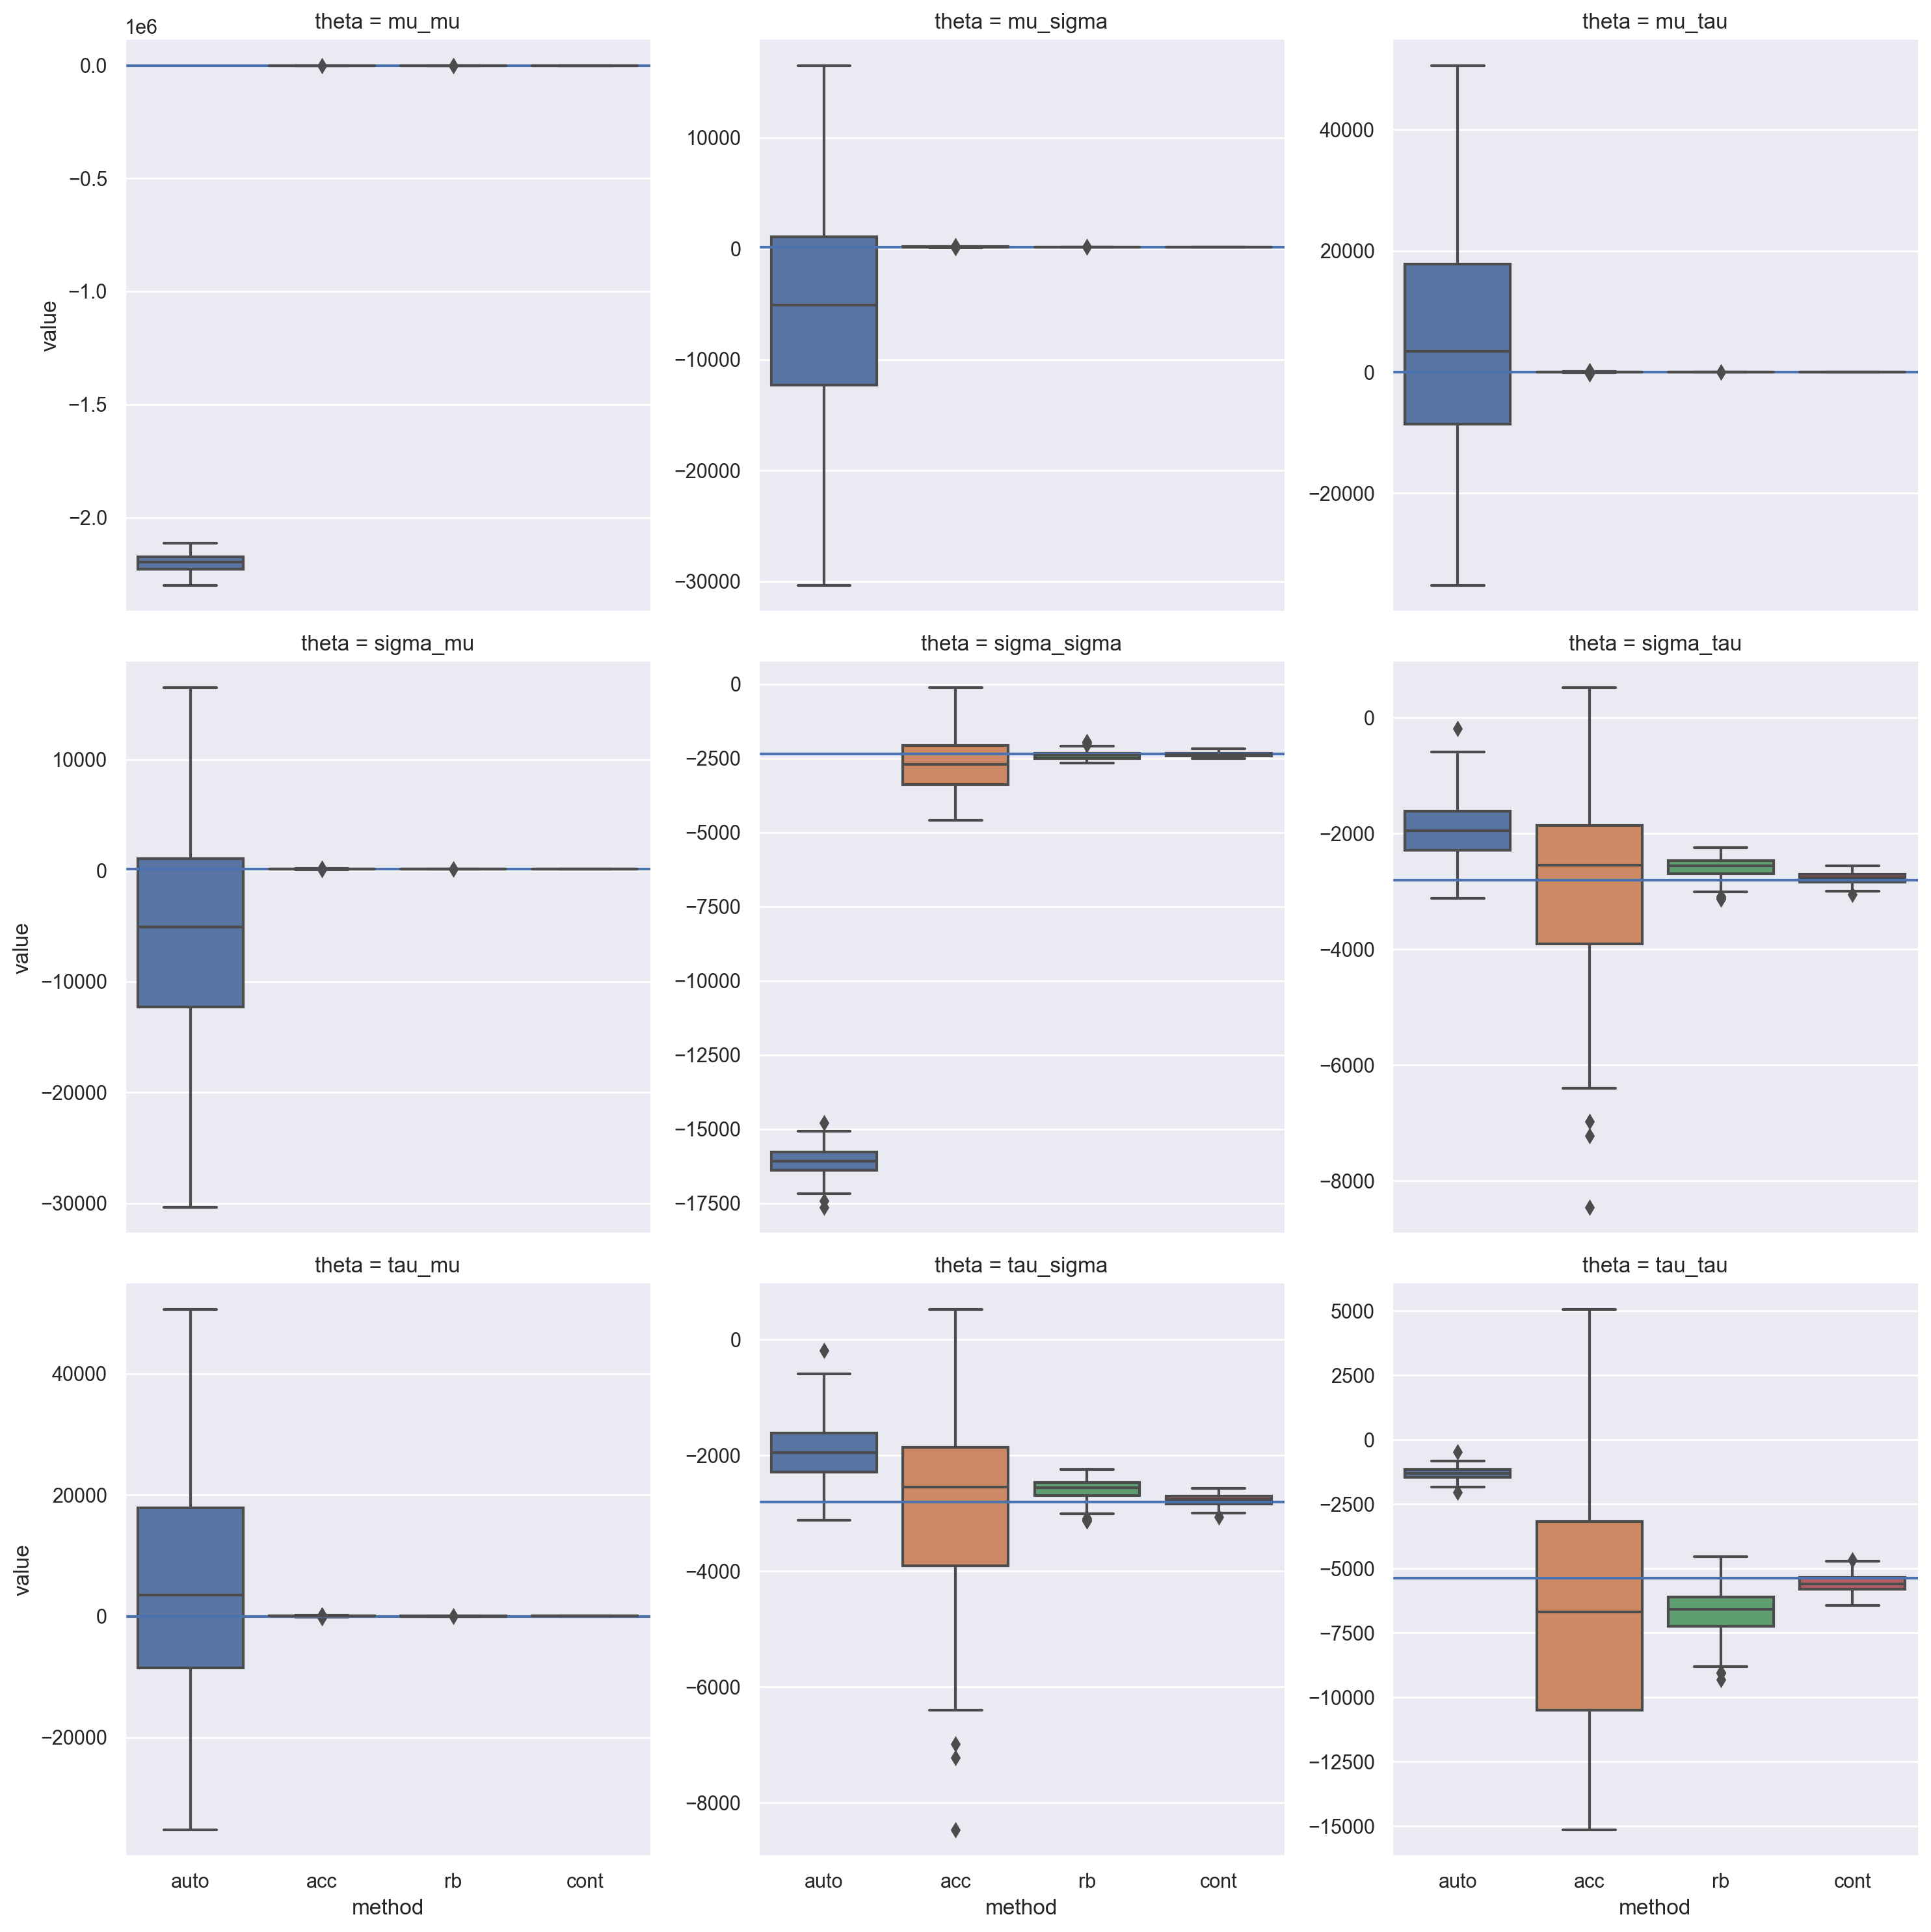

In [25]:
theta2_names = np.meshgrid(np.array(theta_names), np.array(theta_names))
theta2_names = np.array(
    [theta2_names[1].ravel()[i] + '_' +
     theta2_names[0].ravel()[i]
     for i in range(theta2_names[0].size)]
)

plot_df = (
    pd.DataFrame({
    "theta": np.tile(theta2_names, n_sim),
    "auto": np.array(fisher_auto).ravel(),
    "acc": np.array(fisher_acc).ravel(),
    "rb": np.array(fisher_rb).ravel(),
    "cont": np.array(fisher_cont).ravel()
})
    .melt(id_vars=["theta"], value_vars=["auto", "acc", "rb", "cont"], var_name="method")
)

g = sns.catplot(
    data=plot_df, kind="box",
    x="method", y="value",
    col="theta",
    col_wrap=3,
    sharey=False
)
[g.axes[i].axhline(fisher_exact.ravel()[i]) for i in range(theta2_names.size)];

# LotVo Model

In [59]:
# parameter values
alpha = 1.0
beta = 1.0
gamma = 4.0
delta = 1.0
sigma_h = 0.1
sigma_l = 0.1
tau_h = 0.25
tau_l = 0.25

theta = np.array([alpha, beta, gamma, delta, sigma_h, sigma_l, tau_h, tau_l])
theta_names = ["alpha", "beta", "gamma", "delta",
               "sigma_h", "sigma_l", "tau_h", "tau_l"]
theta_lims = np.array(list(zip(theta - (theta/2), theta + (theta/2))))

dt = 0.1
n_res = 1
n_obs = 100

_key = random.PRNGKey(0)
_key, _subkey = random.split(_key)

In [60]:
lotvol_model = LotVolModelLog(dt, n_res, bootstrap = True) 
theta = jnp.log(theta)

x_init = jnp.block([[jnp.zeros((n_res-1, 2))],
                    [jnp.log(jnp.array([5., 3.]))]])

y_meas, x_state = pf.simulate(model = lotvol_model, 
                              n_obs = n_obs, 
                              x_init = x_init, 
                              theta = theta, 
                              key = _subkey)

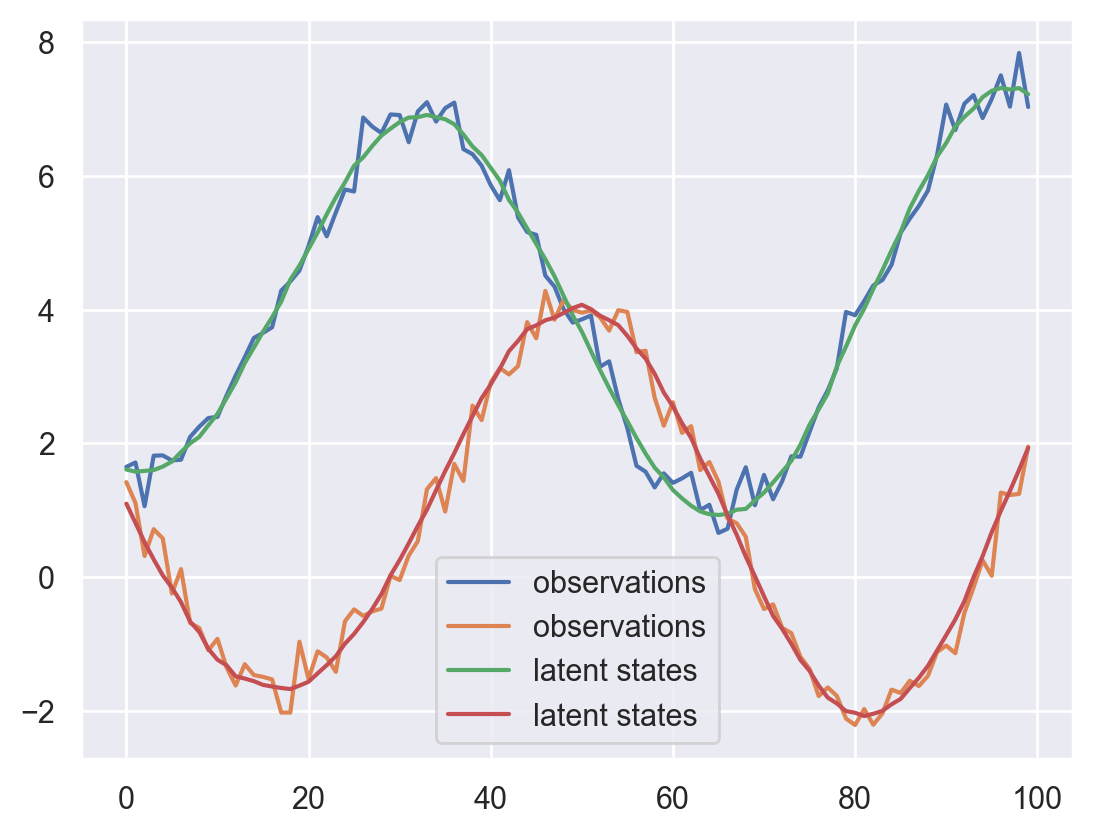

In [61]:
plt.plot(y_meas, label = "observations");
plt.plot(x_state.squeeze(), label = "latent states")
plt.legend();

In [62]:
theta_lims = jnp.log(jnp.array([
    [0.8, 1.2],
    [0.9, 1.1],
    [3.8, 4.2],
    [0.95, 1.05],
    [0.05, 0.2],
    [0.01, 0.2],
    [0.1, 0.4],
    [0.1, 0.4]]))

# theta_lims = jnp.log(jnp.array([
#     [0.95, 1.05],
#     [0.95, 1.05],
#     [3.95, 4.05],
#     [0.95, 1.05],
#     [0.05, 0.15],
#     [0.05, 0.15],
#     [0.2, 0.3],
#     [0.2, 0.3]]))

In [63]:
@partial(jax.jit, static_argnums=(2,3))
def lotvol_neg_loglik(theta, key, resampler = resampler.resample_mvn, n_particles=100):
    """
    Negative log-likelihood for lotka volterra model (lotvol_model)
    """
    temp = pf.particle_filter(
        theta=theta, 
        model=lotvol_model, 
        y_meas=y_meas, 
        n_particles=n_particles, 
        key=key,
        resampler = resampler)
    return -temp["loglik"]


@partial(jax.jit, static_argnums=(2,))
def particle_neg_loglik_mvn(theta, key, n_particles=500):
    """ negative log-likelihood of PF with MVN resampling """
    ret = pf.particle_filter(
        theta=theta, 
        model=lotvol_model, 
        y_meas=y_meas, 
        n_particles=n_particles, 
        key=key,
        resampler = resampler.resample_mvn)
    return -ret["loglik"]


@partial(jax.jit, static_argnums=(2,))
def particle_neg_loglik_gc(theta, key, n_particles=250):
    """ negative log-likelihood of PF with GC resampling """
    ret = pf.particle_filter(
        theta=theta, 
        model=lotvol_model, 
        y_meas=y_meas, 
        n_particles=n_particles, 
        key=key,
        resampler = resampler.resample_gaussian_copula)
    return -ret["loglik"]


@partial(jax.jit, static_argnums=(2,))
def particle_neg_loglik_bootstrap(theta, key, n_particles=500):
    """ negative log-likelihood of PF with multinomial resampling """
    ret = pf.particle_filter(
        theta=theta, 
        model=lotvol_model, 
        y_meas=y_meas, 
        n_particles=n_particles, 
        key=key)
    return -ret["loglik"]

In [64]:
gc_ll = particle_neg_loglik_gc(theta, key=_key)
print("GC: ", gc_ll)

mvn_ll = particle_neg_loglik_mvn(theta, key=_key)
print("MVN: ", mvn_ll)

bootstrap_ll = particle_neg_loglik_bootstrap(theta, key=_key)
print("Bootstrap: ", bootstrap_ll)

GC:  23.737898274221607
MVN:  24.483298952102587
Bootstrap:  25.633663250600648


In [65]:
# calculate projection plot for exact loglikelihood
df_gc = pjp.proj_plot(
    fun = lambda x: particle_neg_loglik_gc(x, key=_key, n_particles=300), 
    x_opt=theta, 
    x_lims=theta_lims, 
    x_names=theta_names, 
    n_pts=100,
    plot=False
)


# calculate projection plot for exact loglikelihood
df_mvn = pjp.proj_plot(
    fun = lambda x: particle_neg_loglik_mvn(x, key=_key, n_particles=300), 
    x_opt=theta, 
    x_lims=theta_lims, 
    x_names=theta_names, 
    n_pts=100,
    plot=False
)

# calculate projection plot for particle filter loglikelihood
df_multinom = pjp.proj_plot(
    fun=lambda x: particle_neg_loglik_bootstrap(x, key=_key, n_particles=300),
    x_opt=theta, 
    x_lims=theta_lims, 
    x_names=theta_names, 
    n_pts=100,
    plot=False
)

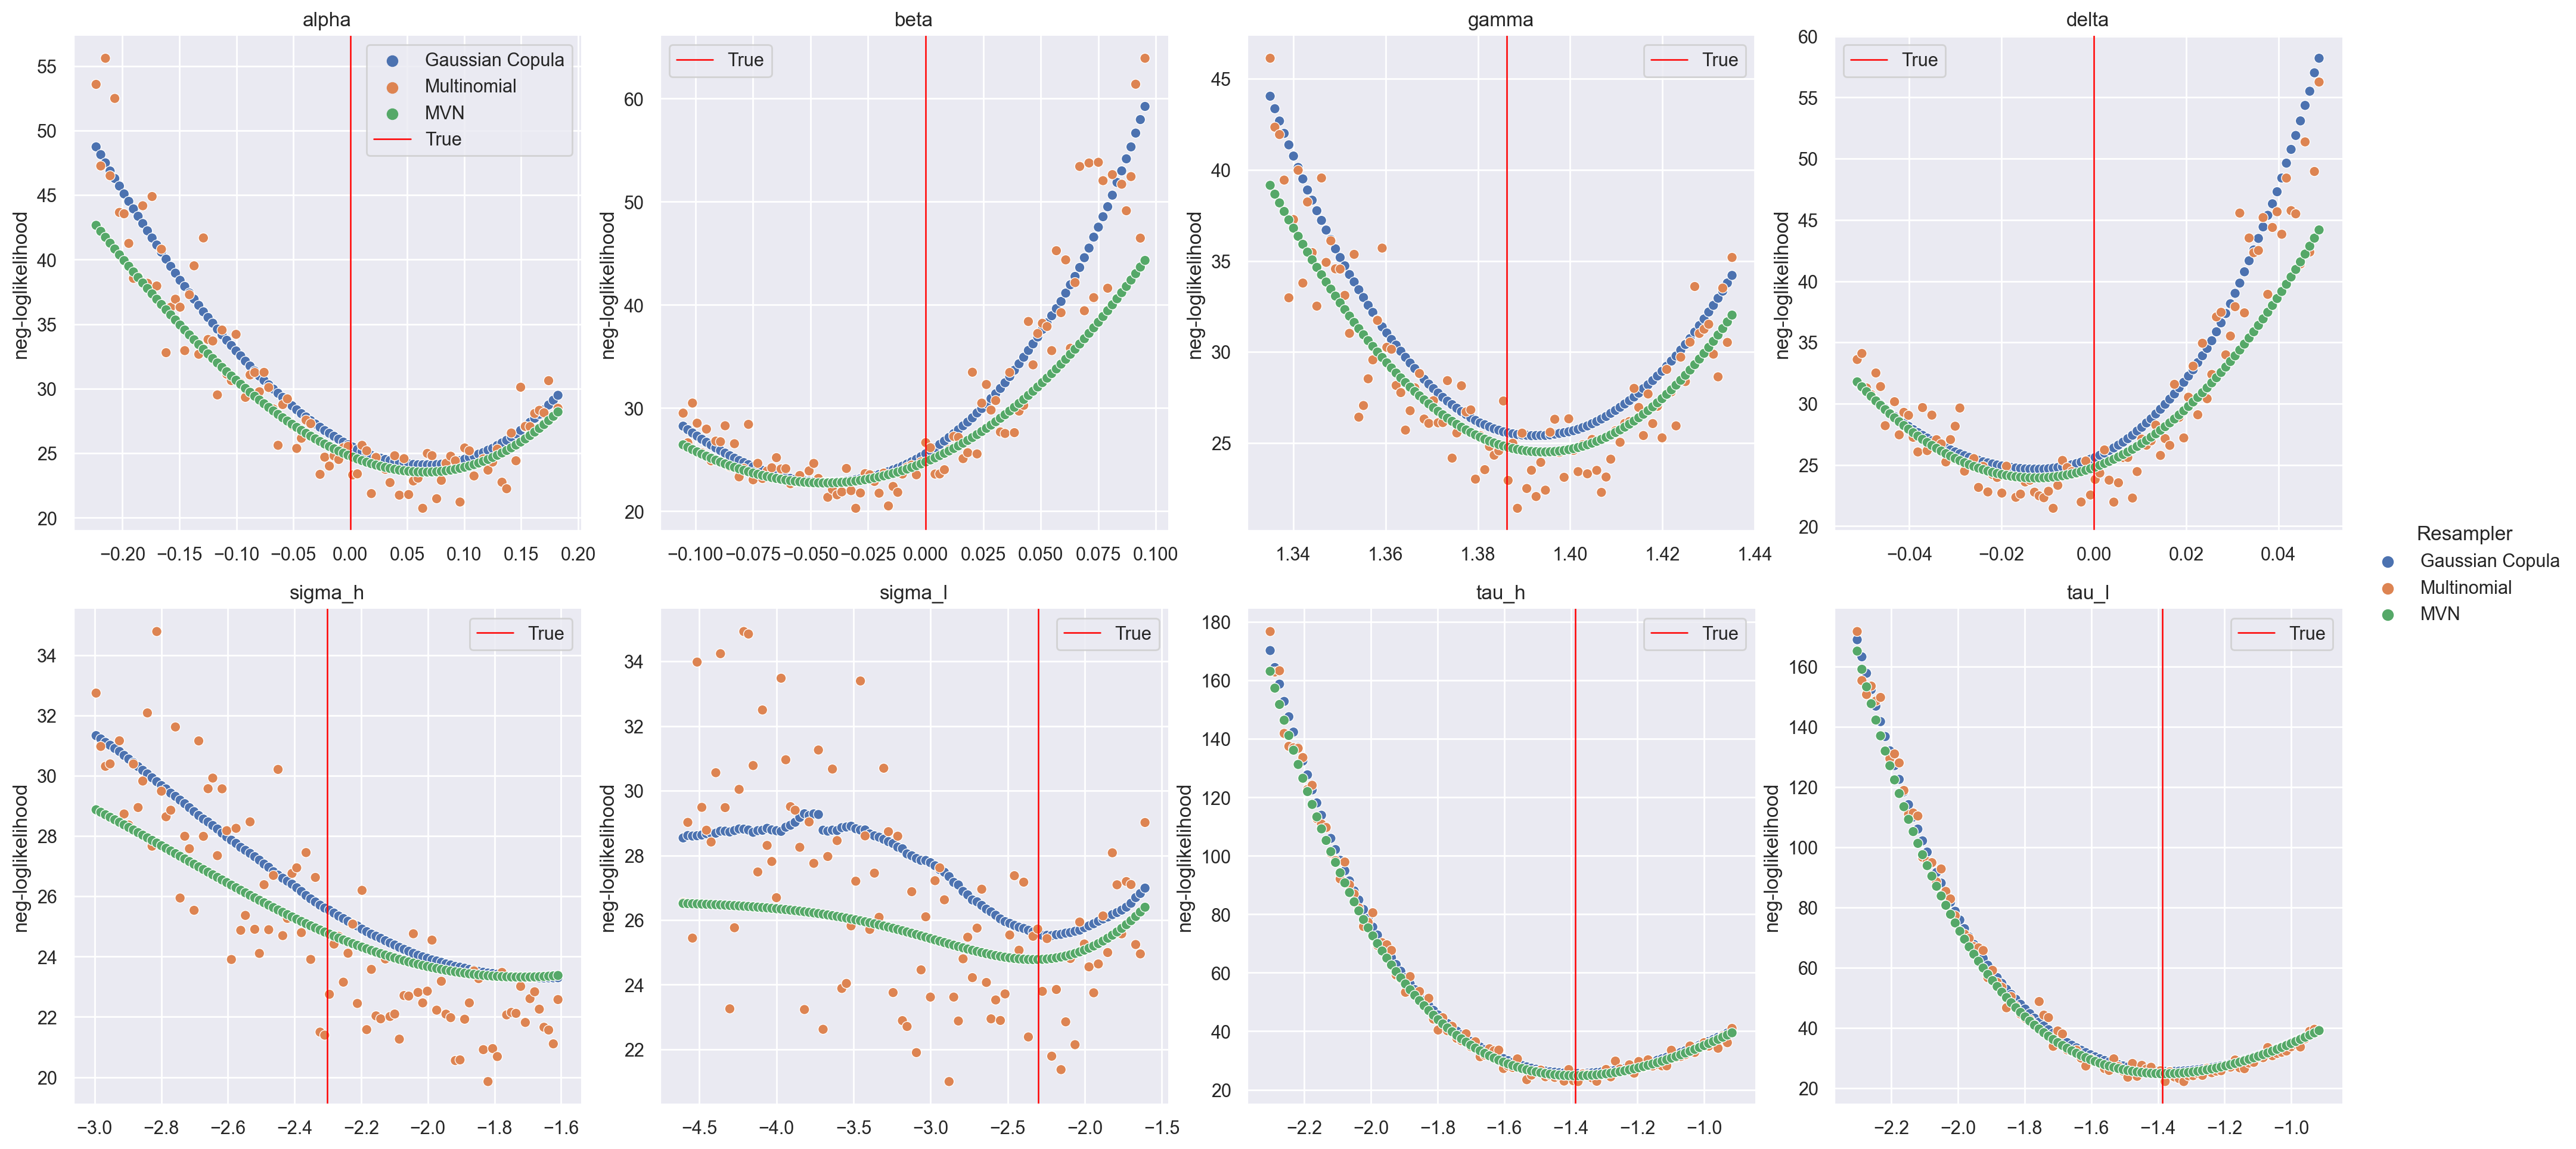

In [66]:
# merge data frames and plot them
plot_df = pd.concat([df_gc, df_multinom, df_mvn], ignore_index=True)
plot_df["Resampler"] = np.repeat(["Gaussian Copula", "Multinomial", "MVN"], len(df_gc["x_opt"]))
plot_df = plot_df.rename(columns={"y": "neg-loglikelihood"})

# plot_df = plot_df[plot_df.x_opt.isin(["alpha", "beta"])]

grid = sns.relplot(
    data=plot_df, #[plot_df.x_opt.isin(["alpha", "beta"])], 
    kind="scatter",
    x="x", y="neg-loglikelihood", 
    hue="Resampler",
    col="x_opt",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
)
grid.set_titles(col_template="{col_name}")
grid.set(xlabel=None);

for ind, _ax in enumerate(grid.axes.flat):
    _ax.axvline(theta[ind], color='red', lw = 0.9, label="True")
    _ax.legend();

## Check Score Function

In [67]:
# various score functions
@partial(jax.jit, static_argnums=(2,))
def lotvol_score_autograd(theta, key, n_particles):
    return jax.grad(lotvol_neg_loglik)(theta, key, n_particles=n_particles)

@partial(jax.jit, static_argnums=(2,))
def lotvol_score_mvn(theta, key, n_particles):
    return jax.grad(particle_neg_loglik_mvn)(theta, key, n_particles=n_particles)

@partial(jax.jit, static_argnums=(2,))
def lotvol_score_gc(theta, key, n_particles):
    return jax.grad(particle_neg_loglik_gc)(theta, key, n_particles=n_particles)

In [68]:
key = random.PRNGKey(0)
n_particles = 1000
key, *subkeys = random.split(key, n_sim+1)

# check timings
%timeit lotvol_score_autograd(theta, key, n_particles)
%timeit lotvol_score_mvn(theta, key, n_particles)
%timeit lotvol_score_gc(theta, key, n_particles)

79.4 ms ± 1.97 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
80.9 ms ± 4.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.17 s ± 338 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [70]:
# repeat calculation nsim times
score_auto = []
score_mvn = []
score_gc = []

for i in range(n_sim):
    score_auto += [lotvol_score_autograd(theta, subkeys[i], n_particles)]
    score_mvn += [lotvol_score_mvn(theta, subkeys[i], n_particles)]
    score_gc += [lotvol_score_gc(theta, subkeys[i], n_particles)]
#     score_cont += [bm_score_cont(theta, subkeys[i], n_particles_cont)]

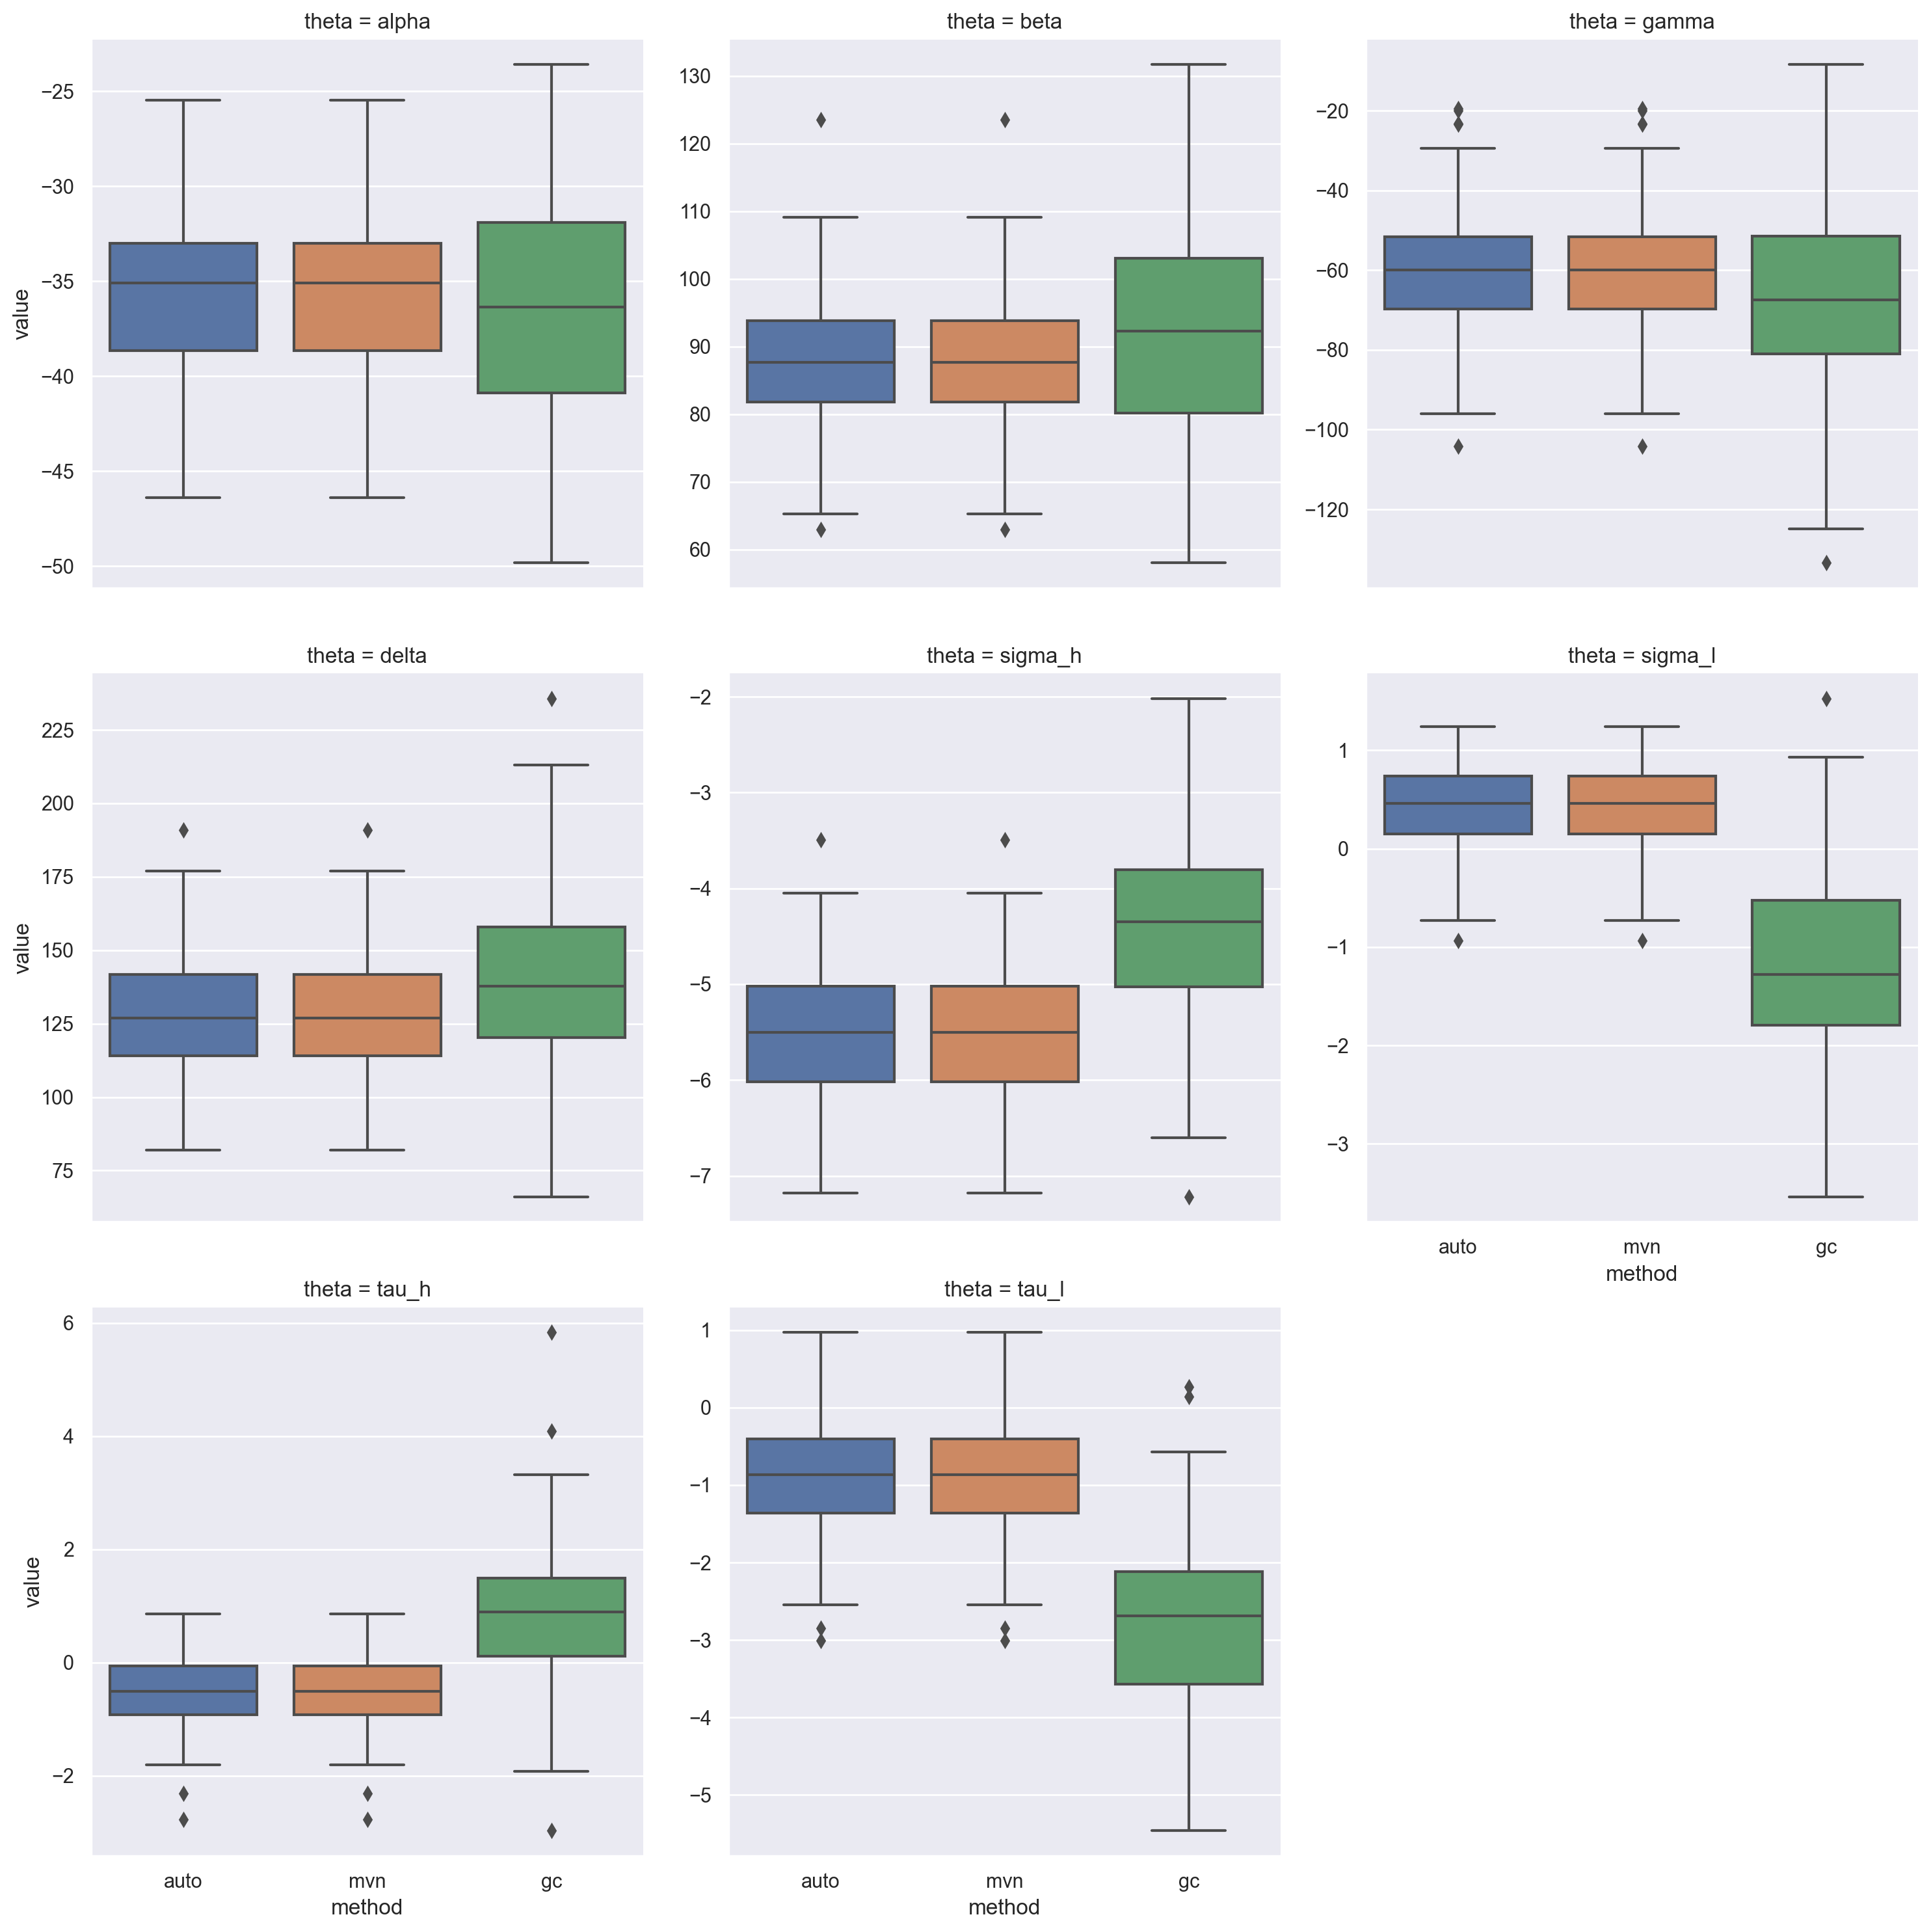

In [71]:
plot_df = (
    pd.DataFrame({
    "theta": np.tile(theta_names, n_sim),
    "auto": np.array(score_auto).ravel(),
    "mvn": np.array(score_mvn).ravel(),
    "gc": np.array(score_gc).ravel()
})
    .melt(id_vars=["theta"], value_vars=["auto", "mvn", "gc"], var_name="method")
)

g = sns.catplot(
    data=plot_df, kind="box",
    x="method", y="value",
    col="theta",
    col_wrap=3,
    sharey=False
);

In [ ]:
# GC projection plots for different keys
# Goal: Is the log-likelihood the same for different keys or does it change? If it does change, we will need 
# to run gradient descent for the same key (i.e. don't update the key at every update step)

_, *subkeys = random.split(_key, 4)

df_gc1 = pjp.proj_plot(
    fun = lambda x: particle_neg_loglik_gc(x, key=jnp.array(subkeys[0]), n_particles=100), 
    x_opt=theta, 
    x_lims=theta_lims, 
    x_names=theta_names, 
    n_pts=100,
    plot=False
)

# calculate projection plot for exact loglikelihood
df_gc2 = pjp.proj_plot(
    fun = lambda x: particle_neg_loglik_gc(x, key=jnp.array(subkeys[1]), n_particles=100), 
    x_opt=theta, 
    x_lims=theta_lims, 
    x_names=theta_names, 
    n_pts=100,
    plot=False
)

# calculate projection plot for exact loglikelihood
df_gc3 = pjp.proj_plot(
    fun = lambda x: particle_neg_loglik_gc(x, key=jnp.array(subkeys[2]), n_particles=100), 
    x_opt=theta, 
    x_lims=theta_lims, 
    x_names=theta_names, 
    n_pts=100,
    plot=False
)


# merge data frames and plot them
_df = pd.concat([df_gc1, df_gc2, df_gc3], ignore_index=True)
_df["Resampler"] = np.repeat(["gc1", "gc2", "gc3"], len(df_gc1["x_opt"]))
_df = _df.rename(columns={"y": "neg-loglikelihood"})

grid = sns.relplot(
    data=_df, kind="line",
    x="x", y="neg-loglikelihood", 
    hue="Resampler",
    col="x_opt",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
)
grid.set_titles(col_template="{col_name}")
grid.set(xlabel=None);

# Stochastic Optimization 

**TODO:**
- [x] Use bridge proposal 
- [ ] Include optimal transport resampling in plots
- [ ] Work precision plots:
    - Benchmark: Take true params and 5k particles (lots of particles)
    - Run basic pf with a diff number of particles with diff seeds each time
    - Evaluate the log-lik on each of these particles 100 times each (multiple times each)
    - Record the runtime per random seed, for each of the number of particles
    - Calculate RMSE for each of the true params and estimated params for each # of particles
    - Plot (clock time VS accuracy) for each method. Doesn't have to be the same number of particle for each method, 

In [ ]:
@partial(jax.jit, static_argnums=(3, 4, ))
def particle_neg_loglik_mvn(theta, key, y_meas, n_particles=500, model=lotvol_model):
    """ negative log-likelihood of PF with MVN resampling """
    ret = pf.particle_filter(
        theta=theta, 
        model=model, 
        y_meas=y_meas, 
        n_particles=n_particles, 
        key=key,
        resampler = resampler.resample_mvn)
    return -ret["loglik"]


@partial(jax.jit, static_argnums=(3, 4, ))
def particle_neg_loglik_gc(theta, key, y_meas, n_particles=500, model=lotvol_model):
    """ negative log-likelihood of PF with GC resampling """
    ret = pf.particle_filter(
        theta=theta, 
        model=model, 
        y_meas=y_meas, 
        n_particles=n_particles, 
        key=key,
        resampler = resampler.resample_gaussian_copula)
    return -ret["loglik"]


@partial(jax.jit, static_argnums=(3, 4, ))
def particle_neg_loglik_bootstrap(theta, key, y_meas, n_particles=500, model=lotvol_model):
    """ negative log-likelihood of PF with multinomial resampling """
    ret = pf.particle_filter(
        theta=theta, 
        model=model, 
        y_meas=y_meas, 
        n_particles=n_particles, 
        key=key)
    return -ret["loglik"]

In [ ]:
%%timeit
bootstrap_ll = particle_neg_loglik_bootstrap(theta, _key, y_meas)

In [ ]:
%%timeit
mvn_ll = particle_neg_loglik_mvn(theta, _key, y_meas)

In [ ]:
%%timeit
gc_ll = particle_neg_loglik_gc(theta, _key, y_meas)

In [ ]:
import time

def update_params(params, subkey, opt_state, grad_fun=None, n_particles=100, 
                  y_meas=None, model=None, learning_rate=0.01, mask=None,
                  optimizer=None):
    loglik_value, params_update = jax.value_and_grad(grad_fun, argnums=0)(
        params, key=subkey, n_particles=n_particles, y_meas=y_meas, model=model)
    params_update = jnp.where(mask, params_update, 0)
    updates, opt_state = optimizer.update(params_update, opt_state)
    return optax.apply_updates(params, updates), loglik_value


def simple_grad_descent (subkey, model, theta, grad_fun, y_meas, n_particles=100, 
                         n_iter=10, learning_rate=0.01, mask=None):
    """ Deterministic optimization """
    optimizer = optax.adam(learning_rate) 
    opt_state = optimizer.init(theta)
    partial_update_params = partial(update_params, n_particles=n_particles, y_meas=y_meas,
                                    model=model, learning_rate=learning_rate, mask=mask, 
                                    grad_fun=grad_fun, optimizer=optimizer)
    update_fn = jax.jit(partial_update_params, donate_argnums=(0,))
    losses = []
    thetas = []
    times = []
    _start = time.time()
    for i in range(n_iter):
        # get value of loss function to make sure we are minimizing 
        start_time = time.perf_counter()
        theta, loglik_value = update_fn(theta, subkey, opt_state)
        times.append(time.perf_counter() - start_time)
        losses.append(loglik_value)
        thetas.append(theta)
    return theta, losses, thetas, times


def grad_descent_scan (key, model, theta, grad_fun, y_meas, n_particles=100, 
                       n_iter=10, learning_rate=0.01, mask=None):
    """ Deterministic optimization """
    _start = time.perf_counter()
    optimizer = optax.adam(learning_rate) 
    opt_state = optimizer.init(theta)
    partial_update_params = partial(update_params, n_particles=n_particles, y_meas=y_meas,
                                    model=model, learning_rate=learning_rate, mask=mask, 
                                    grad_fun=grad_fun, optimizer=optimizer)
    update_fn = jax.jit(partial_update_params, donate_argnums=(0,))

    def scan_fn (carry, i):
        _key, _subkey = random.split(carry["key"])
        theta, loglik_val = update_fn(carry["theta"], _subkey, carry["opt_state"])
        res = {
            "theta": theta,
            "losses": loglik_val}
        return {
            "key": _key,
            "theta": theta,
            "opt_state": opt_state}, res
    
    init_carry = {
        "key": key,
        "theta": init_params,
        "opt_state": opt_state
    }
    carry, res = lax.scan(scan_fn, init_carry, jnp.arange(n_iter))
    
    return {
        "theta": res["theta"][-1],
        "best_theta": res["theta"][jnp.argmin(res["losses"])],
        "steps": res["theta"],
        "losses": res["losses"]}

In [ ]:
init_params = theta #jnp.log(jnp.array([1.1, .9, 3.5, 1.2, 0.1 , 0.1 , 0.25, 0.25])) # true params

# params from multinom filter w/ 10k particles
init_params = jnp.array([-2.00002353e-03, -3.59999848e-02,  1.38029436e+00, 
               -1.20000005e-02, -1.72858508e+00, -4.93258533e+00, -1.47029425e+00, -1.37029437e+00])
# init_params = theta
print("True params:    ", theta)
print("Initial params: ", init_params)

## Fixed Seed

http://www2.stat.duke.edu/~st118/Publication/impsamp.pdf


- Compare gradients, not smoothness of log-likelihood estimates
- Use rao-blackwill method
- Use BM model (update GC for 1-d latent variables)

In [ ]:
# Fix parameters and run both filters with these: 
n_particles = 200
n_iter = 500
learning_rate = 1e-3

start = time.time()
mvn_params, mvn_losses, mvn_steps, mvn_times = simple_grad_descent(
    subkey = _key,
    model = lotvol_model,
    grad_fun = particle_neg_loglik_mvn,
    y_meas = y_meas,
    theta = init_params,
    learning_rate = learning_rate,
    n_iter = n_iter,
    n_particles = n_particles,
    mask=np.ones(len(theta))
)

print("Time: ", time.time() - start)
print("Estimated params: ", mvn_params)
print("MSE: ", jnp.mean((mvn_params - theta)**2))

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 4), sharey = False)
fig.suptitle("MVN Resampling")

ax[0].plot(np.arange(len(mvn_times)), mvn_times, color = "firebrick", label = "Time per update")
ax[1].plot(np.arange(len(mvn_times)), mvn_losses, label = "Losses")

sns.lineplot(pd.DataFrame(np.array(mvn_steps), columns = theta_names),
             ax=ax[2], legend = False)
fig.legend();

In [ ]:
print(np.argmin(mvn_losses))

# check that we have minimized the negative log-lik: Hessian should be positive definite: 
mvn_hessian = jax.jacfwd(jax.jacrev(particle_neg_loglik_mvn))
hess = mvn_hessian(
    mvn_params,
    _key,
    n_particles=500,
    y_meas=y_meas,
    model=lotvol_model)

print("Is positive definite?: ", jnp.all(jnp.linalg.eigvals(hess) >= 0))
print("Diag of inverse: ", np.diag(jnp.linalg.inv(hess)))

var = jnp.linalg.inv(hess)
mle_samples = random.multivariate_normal(key=_key, mean=mvn_params, cov=var, shape=(5_000, ))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(theta_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)
plt.show();

In [ ]:
# Fix parameters and run both filters with these: 
n_particles = 500
n_iter = 200
learning_rate = 1e-4

start = time.time()
gc_params, gc_losses, gc_steps, gc_times = simple_grad_descent(
    subkey = _key,
    model = lotvol_model,
    grad_fun = particle_neg_loglik_gc,
    y_meas = y_meas,
    theta = gc_params, # Initialize with optimized multinomial
    learning_rate = learning_rate,
    n_iter = n_iter,
    n_particles = n_particles,
    mask=np.ones(len(theta))
)

print("Time: ", time.time() - start)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 4), sharey = False)
fig.suptitle("Gaussian Copula Resampling")

ax[0].plot(np.arange(len(gc_times)), gc_times, label = "Time")
ax[1].plot(np.arange(len(gc_times)), gc_losses, label = "Losses")
sns.lineplot(pd.DataFrame(np.array(gc_steps), columns = theta_names),
             ax=ax[2], legend = True);

In [ ]:
gc_hessian = jax.jacfwd(jax.jacrev(particle_neg_loglik_gc))
hess = gc_hessian(
    gc_params,
    _key,
    n_particles=n_particles,
    y_meas=y_meas,
    model=lotvol_model)

print("Is positive definite?: ", jnp.all(jnp.linalg.eigvals(hess) >= 0))
print("Diag of inverse: ", np.diag(jnp.linalg.inv(hess)))

var = jnp.linalg.inv(hess)
mle_samples = random.multivariate_normal(key=_key, mean=gc_params, cov=var, shape=(5_000, ))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8), sharey = True)
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(theta_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)
plt.show();

In [ ]:
# Fix parameters and run both filters with these: 
n_particles = 10_000
n_iter = 100
learning_rate = 1e-3

start = time.time()
multinom_params, multinom_losses, multinom_steps, multinom_times = simple_grad_descent(
    subkey = _key,
    model = lotvol_model,
    grad_fun = particle_neg_loglik_bootstrap,
    y_meas = y_meas,
    theta = init_params,
    learning_rate = learning_rate,
    n_iter = n_iter,
    n_particles = n_particles,
    mask=np.ones(len(theta))
)

print("Time: ", time.time() - start)
print("Estimated params: ", multinom_params)
print("True params: ", theta)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 4), sharey = False)
fig.suptitle("Multinomial Resampling")

ax[0].plot(np.arange(len(multinom_times)), multinom_times, label = "Time")
ax[1].plot(np.arange(len(multinom_times)), multinom_losses, label = "Losses")
sns.lineplot(pd.DataFrame(np.array(multinom_steps), columns = theta_names),
             ax=ax[2], legend = False);

In [ ]:
print(np.argmin(multinom_losses))
multinom_hessian = jax.jacfwd(jax.jacrev(particle_neg_loglik_bootstrap))
hess = multinom_hessian(
    multinom_params,
    _key,
    n_particles=1000,
    y_meas=y_meas,
    model=lotvol_model)

print("Is positive definite?: ", jnp.all(jnp.linalg.eigvals(hess) >= 0))

var = jnp.linalg.inv(hess)
mle_samples = random.multivariate_normal(key=_key, mean=multinom_params, cov=var, shape=(5_000, ))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8), sharey = False)
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(theta_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)
plt.show();

In [ ]:
grid = sns.relplot(
    data=plot_df,
    kind="line",
    x="x", y="neg-loglikelihood", 
    hue="Resampler",
    col="x_opt",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
)
grid.set_titles(col_template="{col_name}")
grid.set(xlabel=None)

for ind, _ax in enumerate(grid.axes.flat):
    _ax.axvline(gc_params[ind], color='firebrick', label="GC")
#     _ax.axvline(mvn_params[ind], color='black', label="MVN")
    _ax.axvline(multinom_params[ind], label="Multinom")
    _ax.legend();

## Change Seed

In [ ]:
# Fix parameters and run both filters with these: 
n_particles = 500
n_iter = 50
learning_rate = 1e-3

start = time.time()
gc_res = grad_descent_scan(
    key = _key,
    model = lotvol_model,
    grad_fun = particle_neg_loglik_gc,
    y_meas = y_meas,
    theta = init_params,
    learning_rate = learning_rate,
    n_iter = n_iter,
    n_particles = n_particles,
    mask=np.ones(len(theta))
)

print("Time: ", time.time() - start)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharey = False)
fig.suptitle("Gaussian Copula Resampling")

ax[0].plot(np.arange(len(gc_res["losses"])), gc_res["losses"], label = "Losses")
sns.lineplot(pd.DataFrame(np.array(gc_res["steps"]), columns = theta_names),
             ax=ax[1], legend = True);

In [ ]:
gc_hessian = jax.jacfwd(jax.jacrev(particle_neg_loglik_gc))
hess = gc_hessian(
    gc_res["theta"],
    _key,
    n_particles=n_particles,
    y_meas=y_meas,
    model=lotvol_model)

print("Is positive definite?: ", jnp.all(jnp.linalg.eigvals(hess) >= 0))
print("Diag of inverse: ", np.diag(jnp.linalg.inv(hess)))

var = jnp.linalg.inv(hess)
mle_samples = random.multivariate_normal(key=_key, mean=gc_res["theta"], cov=var, shape=(5_000, ))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8), sharey = True)
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(theta_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)
plt.show();

In [ ]:
# Fix parameters and run both filters with these: 
n_particles = 10_000
n_iter = 5_000
learning_rate = 1e-3

start = time.time()
multinom_res = grad_descent_scan(
    key = _key,
    model = lotvol_model,
    grad_fun = particle_neg_loglik_bootstrap,
    y_meas = y_meas,
    theta = init_params,
    learning_rate = learning_rate,
    n_iter = n_iter,
    n_particles = n_particles,
    mask=np.ones(len(theta))
)

print("Time: ", time.time() - start)
print("Estimated params: ", multinom_res["theta"])
print("True params: ", theta)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4), sharey = False)
fig.suptitle("Multinomial Resampling")
ax[0].plot(np.arange(len(multinom_res["losses"])), multinom_res["losses"], label = "Losses")
sns.lineplot(pd.DataFrame(np.array(multinom_res["steps"]), columns = theta_names),
             ax=ax[1], legend = False);

In [ ]:
multinom_hessian = jax.jacfwd(jax.jacrev(particle_neg_loglik_bootstrap))
hess = multinom_hessian(
    multinom_res["theta"],
    _subkey,
    n_particles=n_particles,
    y_meas=y_meas,
    model=lotvol_model)

print("Is positive definite?: ", jnp.all(jnp.linalg.eigvals(hess) >= 0))

var = jnp.linalg.inv(hess)
mle_samples = random.multivariate_normal(key=_key, mean=multinom_res["theta"], cov=var, shape=(5_000, ))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8), sharey = True)
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(theta_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)
plt.show();

## Work-Precision Plots

- Benchmark: Take true params and 5k particles (lots of particles)
- Run basic pf with a diff number of particles with diff seeds each time
- Evaluate the log-lik on each of these particles 100 times each (multiple times each)
- Record the runtime per random seed, for each of the number of particles
- Calculate RMSE for each of the true params and estimated params for each # of particles
- Plot (clock time VS accuracy) for each method. Doesn't have to be the same number of particle for each method, 

In [ ]:
import tqdm

In [ ]:
def run_sim_for (loglik, num_particles, true_params, init_params, n_iters, learning_rates, num_sim=10):
    times = np.zeros((len(num_particles), num_sim))
    mse = np.zeros((len(num_particles), num_sim))
    key = random.PRNGKey(0)
    
    for i in range(len(num_particles)): 
        print("Iteration: ", i)
        
        for j in range(num_sim):
            key, subkey = random.split(key)
            start = time.perf_counter()
            if j % 5 == 0:
                print("   Inner iter: ", j)
            _params, _losses, _steps, _time = simple_grad_descent2(
                subkey = subkey,
                model = lotvol_model,
                grad_fun = loglik,
                y_meas = y_meas,
                theta = init_params,
                learning_rate = learning_rates[i],
                n_iter = n_iters[i],
                n_particles = num_particles[i],
                mask=jnp.ones(len(init_params))
            )
            times[i, j] = time.perf_counter() - start # work measured in clock time
            mse[i, j] = sum((_params - true_params)**2) # MSE of estimates
            
    return times, mse, num_particles


def run_sim (loglik, num_particles, true_params, init_params, n_iters, learning_rates, num_sim=10):
    times = np.zeros(len(num_particles))
    mse = np.zeros(len(num_particles))
    key = random.PRNGKey(10)
    results = []
    for i in tqdm.tqdm(range(len(num_particles))): 
        key, *subkeys = random.split(key, num_sim+1)
        start = time.perf_counter()
        sim_res = jax.vmap(lambda key, lr, n_iter, n_part:
             grad_descent_scan(
                 key = key,
                 model = lotvol_model,
                 grad_fun = loglik,
                 y_meas = y_meas,
                 theta = init_params,
                 learning_rate = lr,
                 n_iter = n_iter,
                 n_particles = n_part,
                 mask=jnp.ones(len(init_params))),
             in_axes = (0, None, None, None))(jnp.array(subkeys), learning_rates[i], n_iters[i], num_particles[i])
        end = time.perf_counter()
        mse[i] = (jnp.mean((sim_res["theta"] - true_params)**2)) # MSE averaged over runs
        times[i] = ((end - start)/num_sim) # average times
        results.append(sim_res)
    return times, mse, num_particles, results

In [ ]:
multinom_particles = [50, 100, 250, 500, 1000]
multinom_times, multinom_mse, multinom_num_particles, multinom_results = run_sim(
    loglik = particle_neg_loglik_bootstrap,
    num_particles = multinom_particles,
    true_params = theta,
    init_params = init_params,
    n_iters = [500, 500, 500, 500, 500],
    learning_rates = [1e-3, 1e-3, 1e-3, 1e-3, 1e-3])

In [ ]:
gc_particles = [10, 25, 50, 100]
gc_times, gc_mse, gc_num_particles, gc_results = run_sim(
    loglik = particle_neg_loglik_gc,
    num_particles = gc_particles,
    true_params = theta,
    init_params = init_params,
    n_iters = [500, 500, 500, 500, 500],
    learning_rates = [1e-3, 1e-3, 1e-3, 1e-3, 1e-3])

In [ ]:
mvn_particles = [50, 100, 250, 500, 1000]
mvn_times, mvn_mse, mvn_num_particles, mvn_results = run_sim(
    loglik = particle_neg_loglik_mvn,
    num_particles = mvn_particles,
    true_params = theta,
    init_params = init_params,
    n_iters = [500, 500, 500, 500, 500],
    learning_rates = [1e-3, 1e-3, 1e-3, 1e-3, 1e-3])

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 4), sharey = False)

ax[0].plot(mvn_times, mvn_mse, label = "MVN")
ax[0].plot(gc_times, gc_mse, label = "GC")
ax[0].plot(multinom_times, multinom_mse, label = "Multinomial")
ax[0].set(title="MSE VS Runtime")
ax[0].legend()

ax[1].plot(multinom_particles, mvn_times,  label = "MVN Resampling")
ax[1].plot(gc_particles, gc_times,  label = "GC Resampling")
ax[1].plot(mvn_particles, multinom_times,  label = "Multinomial Resampling")
ax[1].set(title="Number of Particles VS Runtime")
ax[1].legend()

ax[2].plot(list(map(lambda x: np.min(x["losses"]), mvn_results)), label = "MVNN")
ax[2].plot(list(map(lambda x: np.min(x["losses"]), gc_results)), label = "GC")
ax[2].plot(list(map(lambda x: np.min(x["losses"]), multinom_results)), label = "Multinomial");
ax[2].set(title="Min losses after Gradient Descent")
ax[2].legend();

In [ ]:
## EXPERIMENT: MSE VS number of particles for MVN: 
mvn_particles = np.arange(75, 500, step = 75)
mvn_times, mvn_mse, mvn_num_particles, mvn_results = run_sim(
    loglik = particle_neg_loglik_mvn,
    num_particles = mvn_particles,
    true_params = theta,
    init_params = init_params,
#     n_iters = [500] * len(mvn_particles),
    n_iters = [500, 750, 1000, 1200, 1500, 2000],
    learning_rates = [1e-3] * len(mvn_particles),
    num_sim=100)

multinom_particles = np.arange(75, 500, step = 75)
multinom_times, multinom_mse, multinom_num_particles, multinom_results = run_sim(
    loglik = particle_neg_loglik_bootstrap,
    num_particles = multinom_particles,
    true_params = theta,
    init_params = init_params,
#     n_iters = [500] * len(multinom_particles),
    n_iters = [500, 750, 1000, 1200, 1500, 2000],
    learning_rates = [1e-3] * len(multinom_particles),
    num_sim = 100)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharey = True)

ax[0].plot(mvn_particles, mvn_mse, label = "MVN")
ax[1].plot(multinom_particles, multinom_mse, label = "multinom")
plt.legend();

### Findings and Questions

- As the number of particles increases, the minimum loss from optimization also increases. Why would this happen? Shouldn't it be around the same value? 
- Not much of an improvement in the MSE when we increase the number of particles

- **Q:** Should we use a constant seed for gradient descent? 


# Brownian Motion Model

In [ ]:
from pfjax.models import BMModel

# initial key for random numbers
key = random.PRNGKey(0)
sns.set_style("darkgrid")
# parameter values
mu = 5.
sigma = .2
tau = 1.
theta_true = jnp.array([mu, sigma, tau])
bm_theta_names = ["mu", "sigma", "tau"]

# data specification
dt = .2
n_obs = 100
x_init = jnp.array(0.)

# simulate data
bm_model = BMModel(dt=dt)
key, subkey = random.split(key)
y_meas, x_state = pf.simulate(bm_model, subkey, n_obs, x_init, theta_true)

# plot data
plot_df = (pd.DataFrame({"time": jnp.arange(n_obs) * dt,
                         "x_state": jnp.squeeze(x_state),
                         "y_meas": jnp.squeeze(y_meas)})
           .melt(id_vars="time", var_name="type"))
sns.relplot(
    data=plot_df, kind="line",
    x="time", y="value", hue="type"
)
plt.title("Latent Variable(x_state) and Observation(y_meas)");

In [ ]:
bm_theta_lims = jnp.array([
    [4.8, 5.2],
    [0.1, .3],
    [0.9, 1.1]])

In [ ]:
@partial(jax.jit, static_argnums=(2,))
def bm_neg_loglik_mvn(theta, key, n_particles=500):
    """ negative log-likelihood of PF with MVN resampling """
    ret = pf.particle_filter(
        theta=theta, 
        model=bm_model, 
        y_meas=y_meas, 
        n_particles=n_particles, 
        key=key,
        resampler = resampler.resample_mvn)
    return -ret["loglik"]


@partial(jax.jit, static_argnums=(2,))
def bm_neg_loglik_gc(theta, key, n_particles=250):
    """ negative log-likelihood of PF with GC resampling """
    ret = pf.particle_filter(
        theta=theta, 
        model=bm_model, 
        y_meas=y_meas, 
        n_particles=n_particles, 
        key=key,
        resampler = resampler.resample_gaussian_copula)
    return -ret["loglik"]


@partial(jax.jit, static_argnums=(2,))
def bm_neg_loglik_bootstrap(theta, key, n_particles=500):
    """ negative log-likelihood of PF with multinomial resampling """
    ret = pf.particle_filter(
        theta=theta, 
        model=bm_model, 
        y_meas=y_meas, 
        n_particles=n_particles, 
        key=key)
    return -ret["loglik"]

In [ ]:
# calculate projection plot for exact loglikelihood
df_gc = pjp.proj_plot(
    fun = lambda x: bm_neg_loglik_gc(x, key=_key, n_particles=50), 
    x_opt=theta_true, 
    x_lims=bm_theta_lims, 
    x_names=bm_theta_names, 
    n_pts=300,
    plot=False
)


# calculate projection plot for exact loglikelihood
df_mvn = pjp.proj_plot(
    fun = lambda x: bm_neg_loglik_mvn(x, key=_key, n_particles=50), 
    x_opt=theta_true, 
    x_lims=bm_theta_lims, 
    x_names=bm_theta_names, 
    n_pts=300,
    plot=False
)

# calculate projection plot for particle filter loglikelihood
df_multinom = pjp.proj_plot(
    fun=lambda x: bm_neg_loglik_bootstrap(x, key=_key, n_particles=50),
    x_opt=theta_true, 
    x_lims=bm_theta_lims, 
    x_names=bm_theta_names, 
    n_pts=300,
    plot=False
)

In [ ]:
# merge data frames and plot them
plot_df = pd.concat([df_gc, df_multinom, df_mvn], ignore_index=True)
plot_df["Resampler"] = np.repeat(["Gaussian Copula", "Multinomial", "MVN"], len(df_gc["x_opt"]))
plot_df = plot_df.rename(columns={"y": "neg-loglikelihood"})

grid = sns.relplot(
    data=plot_df, kind="line",
    x="x", y="neg-loglikelihood", 
    hue="Resampler",
    col="x_opt",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
)
grid.set_titles(col_template="{col_name}")
grid.set(xlabel=None)

for ind, _ax in enumerate(grid.axes.flat):
    _ax.axvline(theta[ind], color='red', lw = 0.9, label="True")
    _ax.legend();